<script>
    document.querySelector('head').innerHTML += '<style>.slides { zoom: 1. !important; }</style>';
</script>

# Week 9 - Tree-Based Methods
### Dr. David Elliott

1.1. [Introduction](#intro)

1.2. [General Decision Tree Algorithm](#gen)

1.3. [Specific Decision Tree Algorithms](#spec)

# 1.1. Introduction <a id='intro'></a>

_Tree-based_ methods _stratify_ or _segment_ the predictor space into a number of simple regions<sup>1</sup>. 

As the spliting rules to make these decision regions can be summerised in a tree structure, these approaches are called _decision trees_.

A decision tree can be thought of as breaking data down by asking a series of questions in order to categorise samples into the same class. 

__NOTES__

"_In the context of the different categories of machine learning algorithms that we defined at the beginning of this course, we may categorize decision trees as follows:_
- _Supervised learning algorithm: classification and regression_
- _Optimization method: combinatorial -> greedy search_
- _Eager learning algorithm_
- _Batch learning algorithm_
- _Nonparametric model_
- _Deterministic (vs. stochastic)_"


- Supervised learning algorithm:
- greedy search:
- Eager learning algorithm:
- Batch learning algorithm:
- Nonparametric model:
- Deterministic:


__TODO__
- in the notes explain what these are again.
- have a look through this: https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%208.ipynb

---
https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
from IPython.display import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings # prevent warnings
import joblib # saving models
import itertools

matplotlib.rcParams['animation.embed_limit'] = 30000000.0

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
image_dir = os.path.join(os.getcwd(),"Images")
data_dir = os.path.join(os.getcwd(),"..","Data")

fig_num=0
plt.rcParams['figure.dpi'] = 120
# golden ratio for figures ()
gr = 1.618

height_pix = 500
width_pix = height_pix*gr

height_inch = 4
width_inch = height_inch*gr

In [2]:
# Centered figures in the notebook and presentation
# ...was a real pain to find this:
# https://gist.githubusercontent.com/maxalbert/800b9f06c7b2dd365ea5

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import urllib
import base64
from io import BytesIO, StringIO

def fig2str(fig, format='svg'):
    """
    Return a string containing the raw data of the matplotlib figure in the given format.

    """
    assert isinstance(fig, matplotlib.figure.Figure)
    imgdata = BytesIO()
    fig.savefig(imgdata, format=format, bbox_inches='tight')
    imgdata.seek(0)  # rewind the data
    output = imgdata.getvalue()
    if format == 'svg':
        return output
    else:
        return urllib.parse.quote(base64.b64encode(output))

class MatplotlibFigure(object):
    """
    Thin wrapper around a matplotlib figure which provides a custom
    HTML representation that allows tweaking the appearance

    """
    def __init__(self, fig, centered=False):
        assert isinstance(fig, matplotlib.figure.Figure)
        self.centered = centered

    def _repr_html_(self):
        img_str_png = fig2str(fig, format='png')
        uri = 'data:image/png;base64,' + img_str_png
        html_repr = "<img src='{}'>".format(uri)
        if self.centered:
            html_repr = "<center>" + html_repr + "</center>"
        return html_repr

In [3]:
# TODO: Tidy code here, maybe split it up thoughout the notebook... 
# not sure why I thought this way would be helpful looking back its just confusing :P

col_dict = {
    "Adelie":"#ff7600",
    "Chinstrap":"#c65dcb",
    "Gentoo":"#057576"}

shape_dict = {
    "Adelie":"o",
    "Chinstrap":"s",
    "Gentoo":"X"}

datasets = {}
penguins = sns.load_dataset("penguins")

# dropna
penguins_rm = penguins.dropna()

# keep categorical features
penguins_cat = penguins_rm[["island", "sex", "species"]]
penguins_bin = penguins_cat[penguins_cat.species != "Chinstrap"]
y_bin = penguins_bin[["species"]].replace({'Adelie': 0, 'Gentoo': 1}).values.flatten()
# for the classification data we don't want species there either
penguins_class_feat = penguins_bin.drop("species", axis=1)
datasets['cat'] = {"df":penguins_bin, 
                    "X": penguins_class_feat[["island", "sex"]].values,
                    "y": y_bin,
                    "feats": ["island", "sex"],
                     "class": ['Adelie', 'Gentoo']}


# drop continuous features
penguins_cont = penguins_rm.drop(["island", "sex", "species"], axis=1)

# for the regression data we don't want body_mass_g there either
penguins_reg_feat = penguins_cont.drop(["body_mass_g"], axis=1)

datasets['reg_full'] = {"df":penguins_cont, 
                        "X":penguins_reg_feat.values,
                        "y": penguins_rm[["body_mass_g"]].values.flatten(),
                        "feats": list(penguins_reg_feat.columns)}

# regression datset just to compare flipper length to body mass
datasets['flbm'] = {"df":penguins_cont, 
                    "X":penguins_reg_feat[["flipper_length_mm"]].values,
                    "y": penguins_rm[["body_mass_g"]].values.flatten(),
                    "feats": ["Flipper Length (mm)"]}

# make a binary classification dataset
penguins_class = penguins_rm.drop(["island", "sex"], axis=1)
# for the classification data we don't want species there either
penguins_class_feat = penguins_class.drop("species", axis=1)
y_multi = penguins_class[["species"]].replace({'Adelie': 0, 'Gentoo': 1, "Chinstrap":2}).values.flatten()

datasets['multi'] = {"df":penguins_class, 
                     "X": penguins_class_feat.values,
                     "y": y_multi,
                     "feats": list(penguins_class_feat.columns),
                     "class": ['Adelie', 'Gentoo', "Chinstrap"]}

datasets['multi2'] = {"df":penguins_class, 
                     "X": penguins_class_feat[["flipper_length_mm", "bill_length_mm"]].values,
                     "y": y_multi,
                     "feats": ["flipper_length_mm", "bill_length_mm"],
                     "class": ['Adelie', 'Gentoo', "Chinstrap"]}


penguins_bin = penguins_class[penguins_class.species != "Chinstrap"]
y_bin = penguins_bin[["species"]].replace({'Adelie': 0, 'Gentoo': 1}).values.flatten()
# for the classification data we don't want species there either
penguins_class_feat = penguins_bin.drop("species", axis=1)

datasets['bin'] = {"df":penguins_bin, 
                   "X": penguins_class_feat.values,
                   "y": y_bin,
                   "feats": list(penguins_class_feat.columns),
                   "class": ['Adelie', 'Gentoo']}

datasets['flbl'] = {"df":penguins_bin, 
                    "X": penguins_class_feat[["flipper_length_mm", "bill_length_mm"]].values,
                    "y": y_bin,
                    "feats": ["flipper_length_mm", "bill_length_mm"],
                     "class": ['Adelie', 'Gentoo']}

datasets['blbd'] = {"df":penguins_bin, 
                    "X": penguins_class_feat[["bill_length_mm", "bill_depth_mm"]].values,
                    "y": y_bin,
                    "feats": ["bill_length_mm", "bill_depth_mm"],
                    "class": ['Adelie', 'Gentoo']}

In [4]:
if os.path.exists(os.path.join(data_dir,"palmerpenguins")):
    print("Already Cloned")
else:
    import git
    git.Git(os.getcwd()).clone("https://github.com/allisonhorst/palmerpenguins.git")
    
penguins_fig_dir = os.path.join(data_dir,"palmerpenguins", "man", "figures")

Already Cloned


## __Terminology__<sup>5</sup>

__Root node:__ no incoming edge, zero, or more outgoing edges.

__Internal node:__ one incoming edge, two (or more) outgoing edges.

__Leaf node:__ each leaf node is assigned a class label if nodes are pure; otherwise, the class label is determined by majority vote.

__Parent and child nodes:__ If a node is split, we refer to that given node as the parent node, and the resulting nodes are called child nodes.

__Notes__
- Leaves are typically drawn upside down, so they are at the bottom of the tree

Figure 1: Categorical Decision Tree


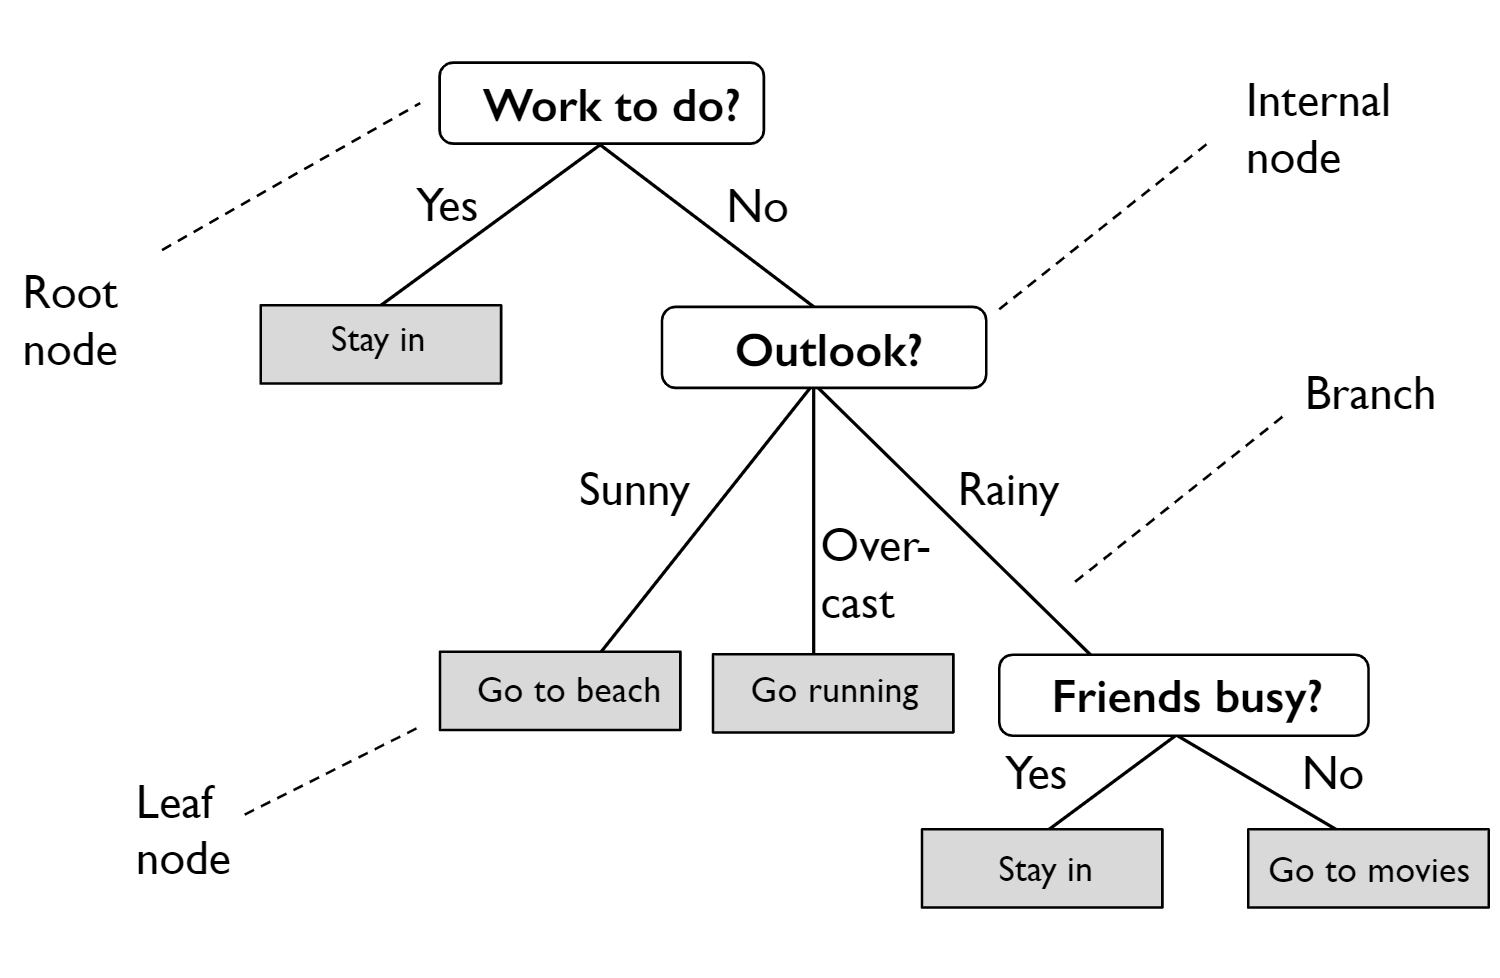

In [5]:
# taken from https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__slides.pdf
# TODO: If I had time I would make my own diagram with "Global Pandemic?" as the second box.
fig_num+=1
print(color.BOLD+color.UNDERLINE+"Figure %d: Categorical Decision Tree"%fig_num+color.END)
Image(os.path.join(image_dir, "tree_terms.png"), width=550)

## Dataset Example: Penguins <a id='data1'></a>
The _"palmer penguins"_ dataset<sup>2</sup> contains data for 344 penguins from 3 different species and from 3 islands in the Palmer Archipelago, Antarctica.
___
Artwork by @allison_horst

Figure 2: Penguin Buddies


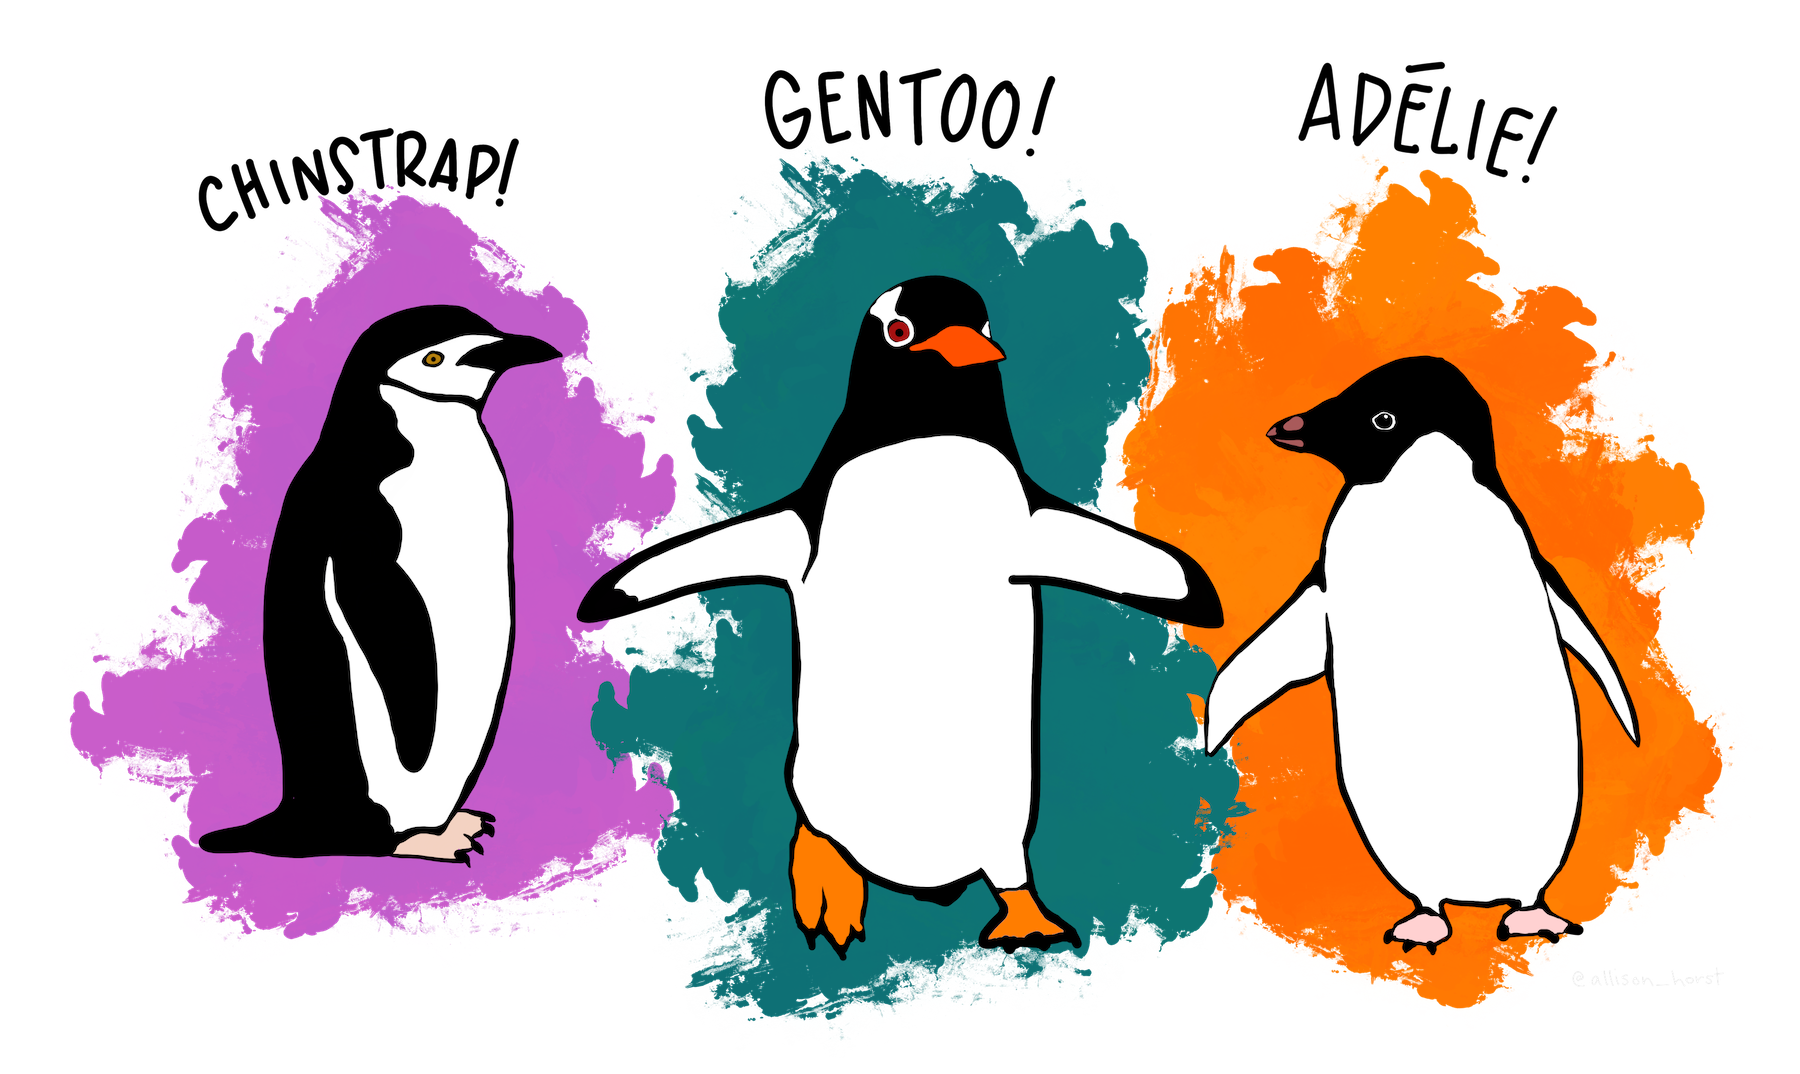

In [6]:
fig_num+=1
print(color.BOLD+color.UNDERLINE+"Figure %d: Penguin Buddies"%fig_num+color.END)
Image(os.path.join(penguins_fig_dir, "lter_penguins.png"), width=600)

In [7]:
display(penguins.head())

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female

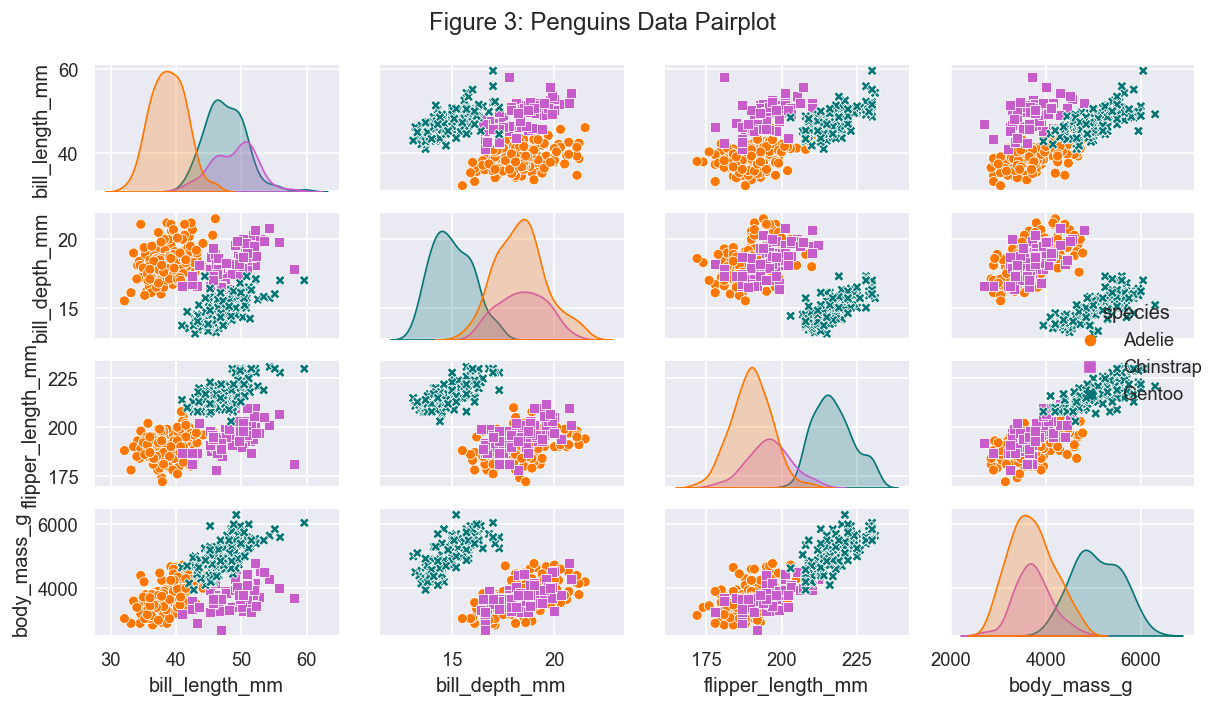

In [8]:
fig_num+=1
sns.pairplot(penguins, hue="species", markers=shape_dict, palette=col_dict, height=1.5, aspect = 1.5)
plt.suptitle("Figure %d: Penguins Data Pairplot"%fig_num)
plt.tight_layout()
plt.show()

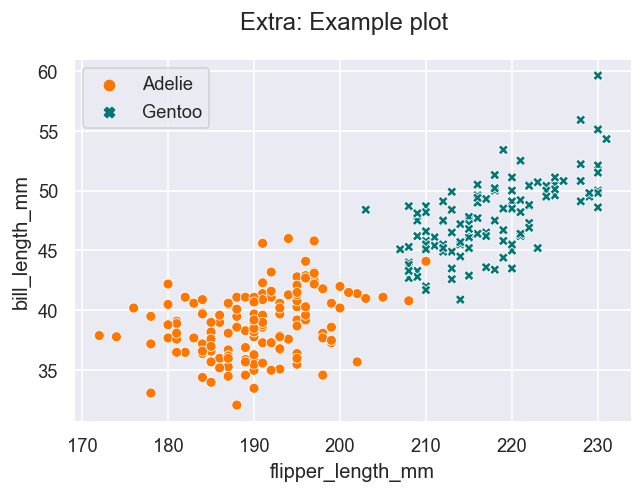

In [9]:
g = sns.scatterplot(data=datasets['flbl']['df'], x = "flipper_length_mm", 
                    y = "bill_length_mm", hue="species", style = "species",
                    markers = shape_dict,  palette= col_dict)
#plt.title("")
g.axes.get_legend().set_title(False)
plt.suptitle('Extra: Example plot')
plt.show()

# 1.3. General Decision Tree Algorithm <a id='gen'></a>

An algorithm starts at a tree root and then splits the data based on the features that give the best split based on a splitting criterion.

Generally this splitting procedure occours until<sup>3,4</sup>... 
- ...all the samples within a given node all belong to the same class, 
- ...the maximum depth of the tree is reached, 
- ...a split cannot be found that improves the model. 

__NOTES__
- The process of growing a decision tree can be expressed as a recursive algorithm as follows<sup>5</sup>:
    1. Pick a feature such that when parent node is split, it results in the largest information gain and stopping if information gain is not positive.
    2. Stop if child nodes are pure or no improvement in class purity can be made.
    3. Go back to step 1 for each of the two child nodes.
    
__TODO__
- I made way to many specific functions below so refactor to make it a bit more managable!

In [10]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn import tree
from re import search

DT_g1 = DecisionTreeClassifier(criterion='gini',
                               max_depth = 1,
                               random_state=42)

l_labels = [[189, 57.5],[219, 57.5]]
r_labels = [[0.225, 0.4],[0.725, 0.4]]
tp_labels = [[0.28, 0.5],[0.64, 0.5]]

def regions_tree(DT, X, y, feature_names, class_names, col_dict, l_label_pos=None, 
                 r_label_pos=None, tp_label_pos=None, impurity = False, 
                 xaxis_lim = None, yaxis_lim = None, color=False, title=None, savefig=None):
    DT.fit(X,y)

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    plt.sca(axes[0])

    scatter_kwargs = {"c":col_dict, "marker":shape_dict}
    ax = plot_decision_regions(X, y, clf = DT,
                               markers = ','.join([shape_dict[x] for x in class_names]),
                               colors = ','.join([col_dict[x] for x in class_names])
                              )

    handles, labels = ax.get_legend_handles_labels()
    
    if l_label_pos:
        plt.text(l_label_pos[0][0], l_label_pos[0][1], "$R_1$", bbox=dict(facecolor='white', alpha=0.3))
        plt.text(l_label_pos[1][0], l_label_pos[1][1], "$R_2$", bbox=dict(facecolor='white', alpha=0.3))
    
    ax.legend(handles, 
              class_names, 
              framealpha=0.3, scatterpoints=1)

    plt.xlabel(feature_names[0]) 
    plt.ylabel(feature_names[1])
    if xaxis_lim:
        plt.xlim(xaxis_lim)
    if yaxis_lim:
        plt.ylim(yaxis_lim)
    
    # The arrows dont show up on versions of Scikit Learn due to a weird interaction with sns 
    # so I need to use `plt.style.context("classic")`.
    with plt.style.context("classic"):
        plt.sca(axes[1])
        tp = tree.plot_tree(DT,
                       feature_names=feature_names, 
                       class_names=class_names,
                       filled = True,
                           impurity = impurity)
        if r_label_pos:
            axes[1].text(r_label_pos[0][0], r_label_pos[0][1],
                         "$R_1$")
            axes[1].text(r_label_pos[1][0], r_label_pos[1][1], 
                         "$R_2$")
            
        if tp_label_pos:
            axes[1].text(tp_label_pos[0][0], tp_label_pos[0][1],
                         "False", {'fontweight':'bold'})
            axes[1].text(tp_label_pos[1][0], tp_label_pos[1][1], 
                         "True", {'fontweight':'bold'})
        
        for i, node in enumerate(tp):
            for class_name in class_names:
                if search(class_name, node.get_text()):
                    tp[i].set_backgroundcolor(col_dict[class_name])

    if title:
        plt.suptitle(title)
        
    if savefig:
        plt.savefig(savefig)
    plt.show()

Below is an example of a very shallow decision tree where we have set `max_depth = 1`.

__Terminology (Reminder)__<sup>1</sup>
- The regions $R_1$ and $R_2$ are known as _terminal nodes_ or _leaves_ of the tree.
- The points where the predictor space is split are known as the _internal nodes_. In this case as we only have one split this is the  _"root node"_.
- The segments of the trees that connect the nodes are _branches_.

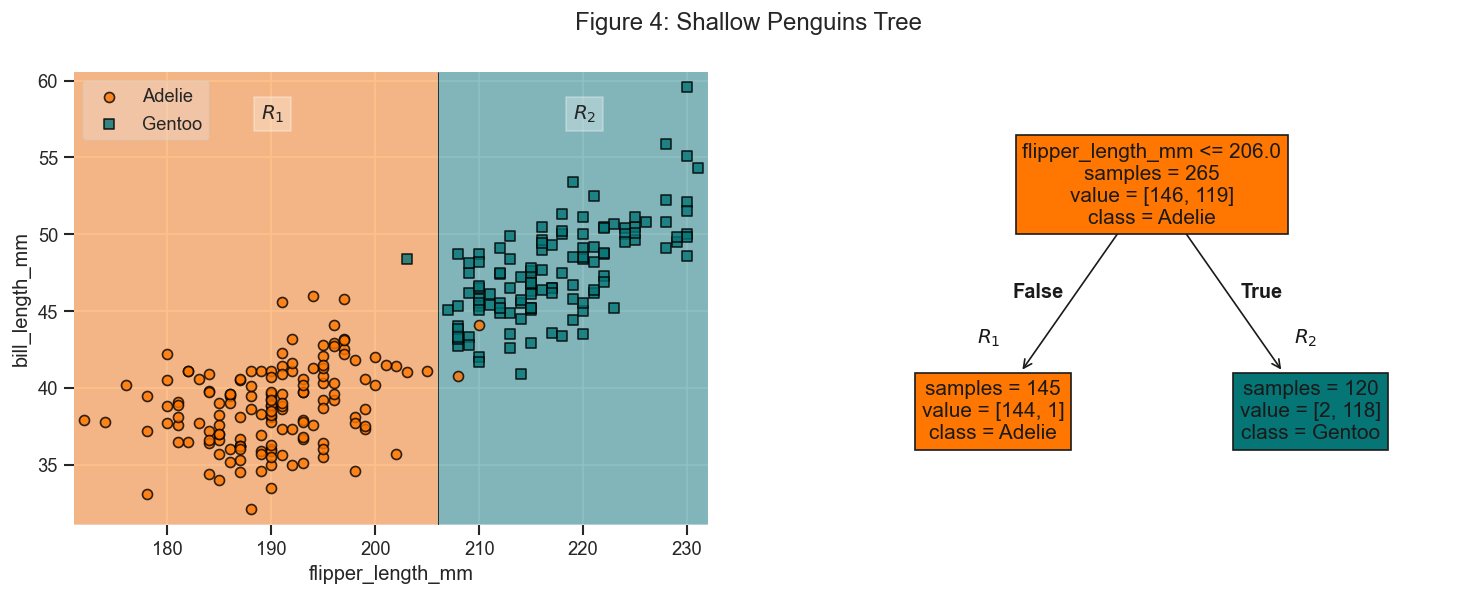

In [11]:
fig_num+=1
regions_tree(DT_g1, datasets['flbl']['X'], datasets['flbl']['y'], 
             datasets['flbl']['feats'], datasets['flbl']['class'], 
             col_dict, l_labels, r_labels, tp_labels, 
             title="Figure %d: Shallow Penguins Tree"%fig_num)

__Extra: `dtreeviz`__

Heres an additional visualisation package with extra features such as bein able to follow the path of a hypothetical test sample. 

I don't use `dtreeviz` in the lectures, as it can be a bit of a hassle to setup. However you may also find this a useful way of thinking about the splitting.

__Notes__

- _"For classifiers, however, the target is a category, rather than a number, so we chose to illustrate feature-target space using histograms as an indicator of feature space distributions."_ https://explained.ai/decision-tree-viz/index.html

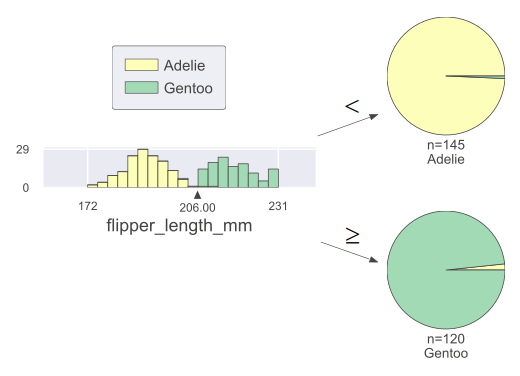

In [12]:
from re import search

# Change to True if you want to run the dtreeviz code
DTREEVIS = True

if DTREEVIS:
    if not search("graphviz", os.environ.get('PATH')):
        # CHANGE THIS TO WHERE graphviz IS ON YOUR COMPUTER!
        GRAPHVIS_PATH = 'C:\\Program Files\\Graphviz\\bin'
        #C:\Users\delliot2\.conda\envs\mlp\Lib\site-packages\graphviz
        os.environ["PATH"] += os.pathsep + GRAPHVIS_PATH
        
    from dtreeviz.trees import dtreeviz
    DT_g1.fit(datasets['flbl']['X'], datasets['flbl']['y'])

    viz = dtreeviz(DT_g1, datasets['flbl']['X'], datasets['flbl']['y'],
                   feature_names=datasets['flbl']['feats'],
                   class_names=['Adelie', 'Gentoo'],
                   orientation ='LR', colors = col_dict, scale=2.0
                  )
    display(viz)

We can make the tree _"deeper"_, and therefore more complex, by setting the `max_depth = 3`.

In [13]:
DT_g3 = DecisionTreeClassifier(criterion='gini',
                               max_depth = 3,
                               random_state=42)

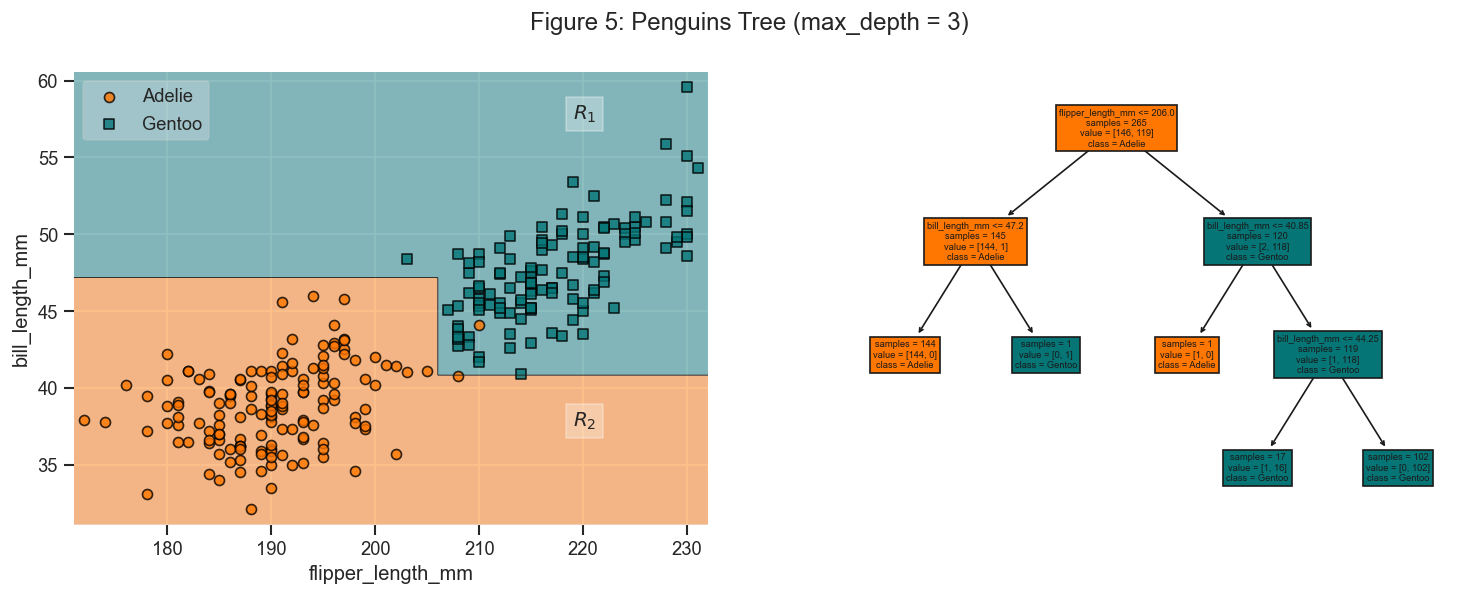

In [14]:
fig_num+=1
regions_tree(DT_g3, datasets['flbl']['X'], datasets['flbl']['y'], 
             datasets['flbl']['feats'], datasets['flbl']['class'], 
             col_dict, [[219, 57.5],[219, 37.5]], 
             title="Figure %d: Penguins Tree (max_depth = 3)"%fig_num,
             savefig = os.path.join(image_dir,"Soft_Margin_Hyperplane.png")
            )

We could also use more than 2 features as seen below.

__NOTES__
- Although more features are harder to plot decision boundaries (see `dtreeviz`).

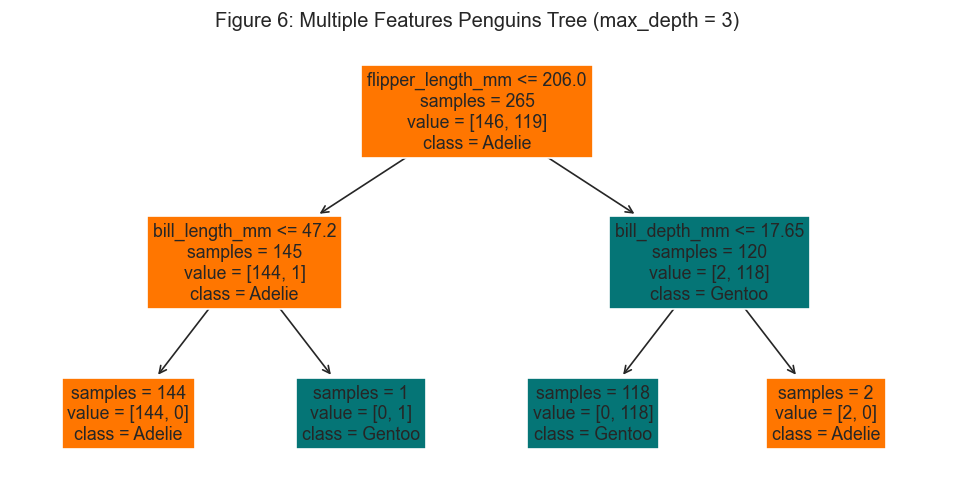

In [15]:
# TODO: time allowing, do a 3d plot of the decision boundary.
DT_g = DecisionTreeClassifier(criterion='gini',
                              max_depth = 3,
                              random_state=42)
DT_g.fit(datasets['bin']['X'], datasets['bin']['y'])

fig, axes = plt.subplots(figsize=(10, 5))
tp = tree.plot_tree(DT_g,
                    feature_names=datasets['bin']['feats'], 
                    class_names=datasets['bin']['class'],
                    filled = True,
                   impurity = False,
               ax=axes
              )

for i, node in enumerate(tp):
    for class_name in datasets['bin']['class']:
        if search(class_name, node.get_text()):
            tp[i].set_backgroundcolor(col_dict[class_name])

fig_num+=1            
plt.title("Figure %d: Multiple Features Penguins Tree (max_depth = 3)"%fig_num)
plt.savefig(os.path.join(image_dir, "figurex.png"))
plt.show()

We could also also easily extend this to have more than a 2 (binary) class labels.

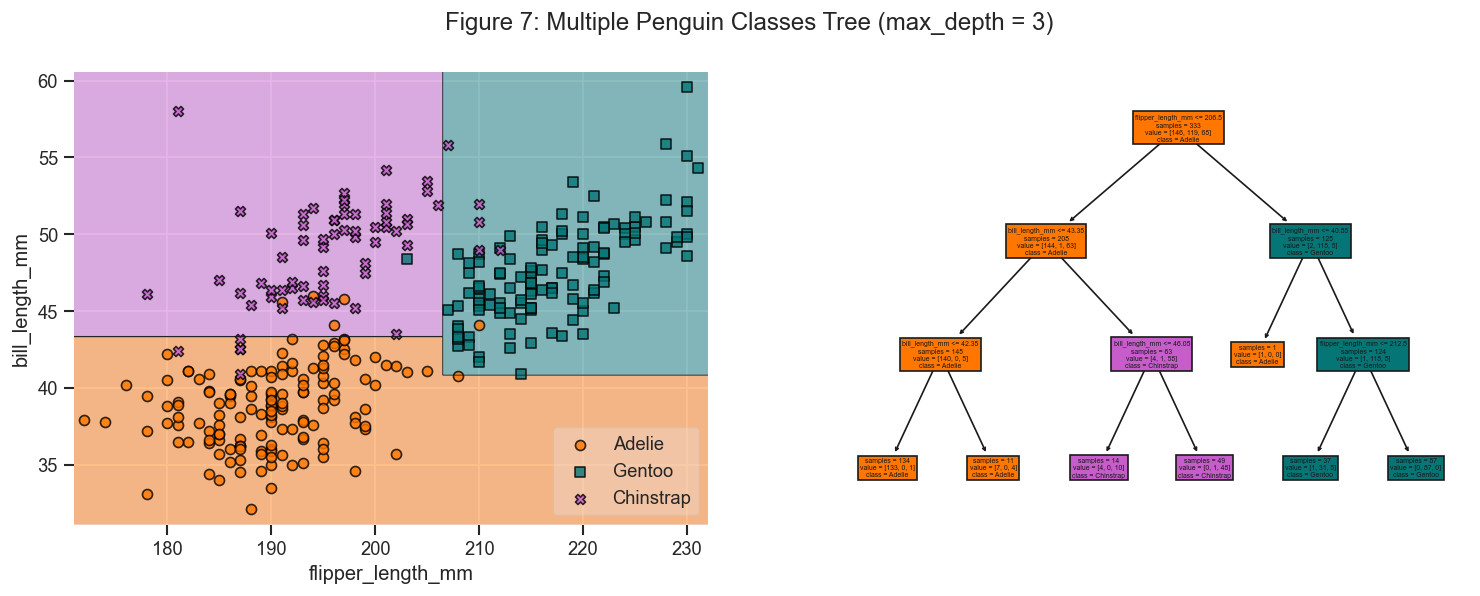

In [16]:
fig_num+=1   
regions_tree(DT_g, datasets['multi2']['X'], datasets['multi2']['y'], 
             datasets['multi2']['feats'], datasets['multi2']['class'], 
             col_dict,
             title="Figure %d: Multiple Penguin Classes Tree (max_depth = 3)"%fig_num
            )         
plt.show()

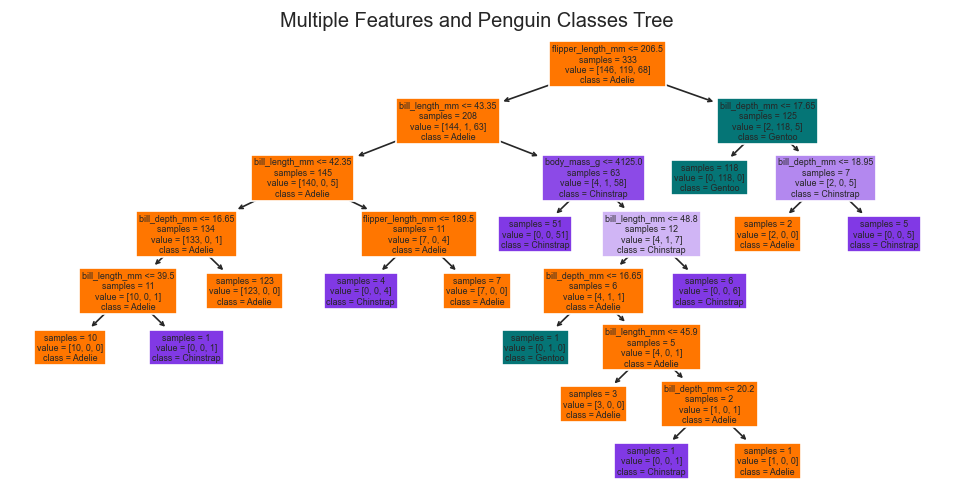

In [17]:
DT_g = DecisionTreeClassifier(criterion='gini',
                               random_state=42)
DT_g.fit(datasets['multi']['X'], datasets['multi']['y'])

fig, axes = plt.subplots(figsize=(10, 5))
tp = tree.plot_tree(DT_g,
                    feature_names=datasets['multi']['feats'], 
                    class_names=datasets['multi']['class'],
                    filled = True,
                   impurity = False,
               ax=axes
              )
for i, node in enumerate(tp):
    for class_name in datasets['bin']['class']:
        if search(class_name, node.get_text()):
            tp[i].set_backgroundcolor(col_dict[class_name])

plt.title("Multiple Features and Penguin Classes Tree")
plt.savefig(os.path.join(image_dir, "figurey.png"))
plt.show()

In a general sense this approach is pretty simple, however there are a number of design choices and considerations we have to make including<sup>5</sup>:
- How do we decide which features to select for splitting a parent node into child nodes?
- How do we decide where to split features?
- When do we stop growing a tree?
- How do we make predictions if no attributes exist to perfectly separate non-pure nodes further?

# 1.4. Specific Decision Tree Algorithms <a id='spec'></a>

Most decision tree algorithms address the following implimentation choices differently<sup>5</sup>:
- __Splitting Criterion:__ Information gain, statistical tests, objective function, etc.
- __Number of Splits:__ Binary or multi-way.
- __Variables:__ Discrete vs. Continuous.
- __Pruning__: Pre- vs. Post-pruning.

There are a number of decision tree algorithms, prominant ones include:
- Iterative Dichotomizer 3 (ID3)
- C4.5
- __CART__

__Notes__

- Binary means _nodes_ always have two children.

## CART


Scikit-Learn uses an optimised version of the Classification And Regression Tree (CART) algorithm.

- __Splitting Criterion:__ Information gain
- __Number of Splits:__ Binary
- __Independent Variables (Features):__ Continuous
- __Dependent variable__: Continuous or Categorical
- __Pruning__: Pre- & Post-pruning

__Notes__

- _"scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now."_ https://scikit-learn.org/stable/modules/tree.html

## Information Gain<sup>4</sup>

An algorithm starts at a tree root and then splits the data based on the feature, $f$, that gives the largest information gain, $IG$. 

To split using information gain relies on calculating the difference between an impurity measure of a parent node, $D_p$, and the impurities of its child nodes, $D_j$; information gain being high when the sum of the impurity of the child nodes is low.

We can maximise the information gain at each split using,

$$IG(D_p,f) = I(D_p)-\sum^m_{j=1}\frac{N_j}{N_p}I(D_j),$$

where $I$ is out impurity measure, $N_p$ is the total number of samples at the parent node, and $N_j$ is the number of samples in the $j$th child node.

Some algorithms, such as Scikit-learn's implimentation of CART, reduce the potential search space by implimenting binary trees:

$$IG(D_p,f) = I(D_p) - \frac{N_\text{left}}{N_p}I(D_\text{left})-\frac{N_\text{right}}{N_p}I(D_\text{right}).$$

Three impurity measures that are commonly used in binary decision trees are the _classification error_ ($I_E$), _gini impurity_ ($I_G$), and _entropy_ ($I_H$)<sup>4</sup>. 

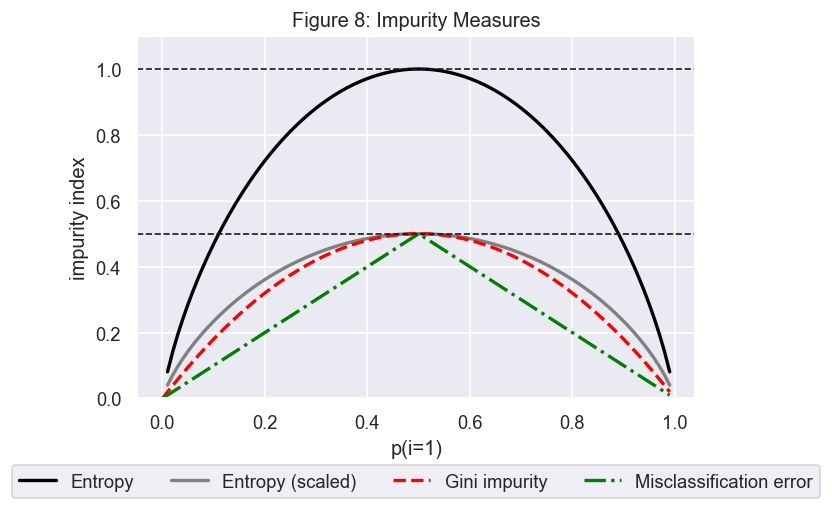

In [18]:
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

# edited from https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch03/ch03.ipynb
def inf_gain_plot(plot_type="All", title=None):

    x = np.arange(0.0, 1.0, 0.01)

    ent = [entropy(p) if p != 0 else None for p in x]
    sc_ent = [e * 0.5 if e else None for e in ent]
    err = [error(i) for i in x]
    
    lab_ls_c = zip([ent, sc_ent, gini(x), err], 
                        ['Entropy', 'Entropy (scaled)', 
                         'Gini impurity', 'Misclassification error'],
                        ['-', '-', '--', '-.'],
                        ['black', 'gray', 'red', 'green', 'cyan'])
    
    if plot_type not in ["All", "Entropy", "Gini", "Misclassification"]:
        print("Not a valid `plot_type`")
        return

    fig = plt.figure()
    ax = plt.subplot(111)
    for i, lab, ls, c, in lab_ls_c:
        alpha = 0.1
        if plot_type == "All":
            alpha = 1.
        elif plot_type == "Entropy" and lab in ['Entropy', 'Entropy (scaled)']:
            alpha = 1.
        elif plot_type == "Gini" and lab == "Gini impurity":
            alpha = 1.
        elif plot_type == "Misclassification" and lab == "Misclassification error":
            alpha = 1.
        
        line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c, alpha=alpha)

    ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.3),
              ncol=5, fancybox=True, shadow=False)

    ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
    ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
    plt.ylim([0, 1.1])
    plt.xlabel('p(i=1)')
    plt.ylabel('impurity index')
    if title:
        plt.title(title)
    plt.show()
    
fig_num+=1
inf_gain_plot(plot_type="All", 
              title="Figure %d: Impurity Measures"%fig_num)

### Classification Error<sup>4</sup>

This is simply the fraction of the training observations in a region that does belongs to the most common class:

$$I_E = 1 - \max\left\{p(i|t)\right\}$$

Here $p(i|t)$ is the proportion of the samples that belong to the $i$th class $c$, for node $t$.

__Notes__
- Another way of writing this is $E = 1 - \substack{max\\k}(\hat p_{mk})$, where $\hat p_{mk}$ is the proportion of training observations in the $m$th region that are from the $k$th class<sup>1</sup>.

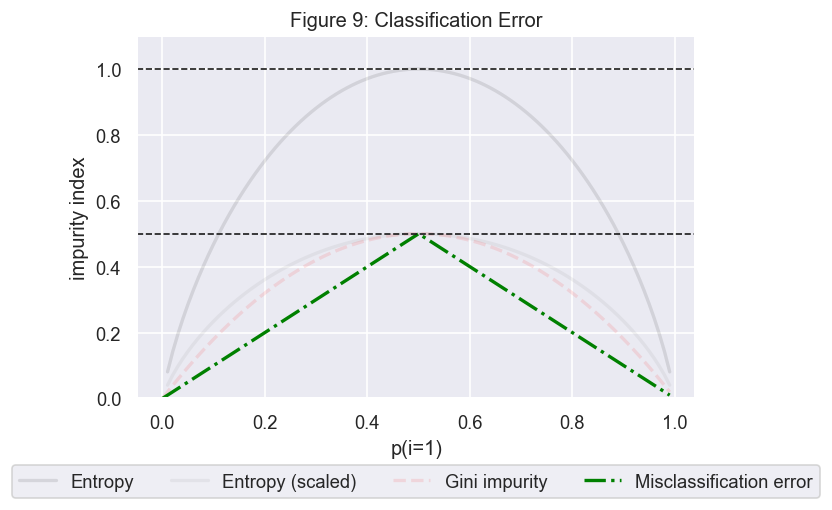

In [19]:
fig_num+=1
inf_gain_plot(plot_type="Misclassification",
              title="Figure %d: Classification Error"%fig_num
             )

### Entropy Impurity<sup>4</sup>
For all non-empty classes ($p(i|t) \neq 0$), entropy is given by

$$I_H=-\sum^c_{i=1}p(i|t)\log_2p(i|t).$$

The entropy is therefore 0 if all samples at the node belong to the same class and maximal if we have a uniform class distribution.

For example in binary classification ($c=2$):
- $I_H=0 \text{ if } p(i=1|t)=1 \text{ or } p(i=0|t)=0$
- $I_H=1 \text{ if } p(i=1|t)=0.5 \text{ or } p(i=0|t)=0.5$

__Notes__

- In binary classification, entropy reaches its minimum (0) when all examples in a given node have the same label; on the other hand, the entropy is at its maximum of 1 when exactly one-half of examples a node are labeled with 1, which would be useless for classification.<sup>6</sup>
- Another way of writing this is<sup>1</sup> $D = -\sum^K_{k=1}\hat p_{mk}log \hat p_{mk}$.
    - Entropy will take on a value near 0 if the $\hat p_{mk}$'s are all near 0 or 1, therefore will take on a small value if the $m$th node is pure.

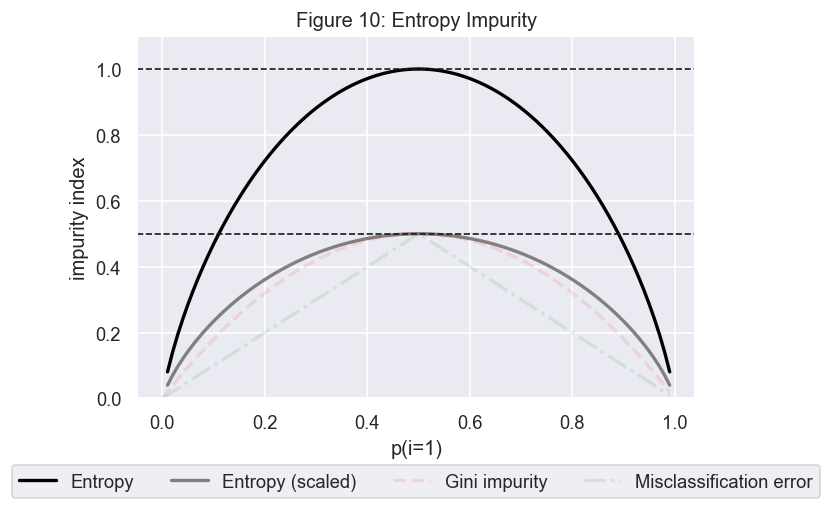

In [20]:
fig_num+=1
inf_gain_plot(plot_type="Entropy",
              title="Figure %d: Entropy Impurity"%fig_num
             )

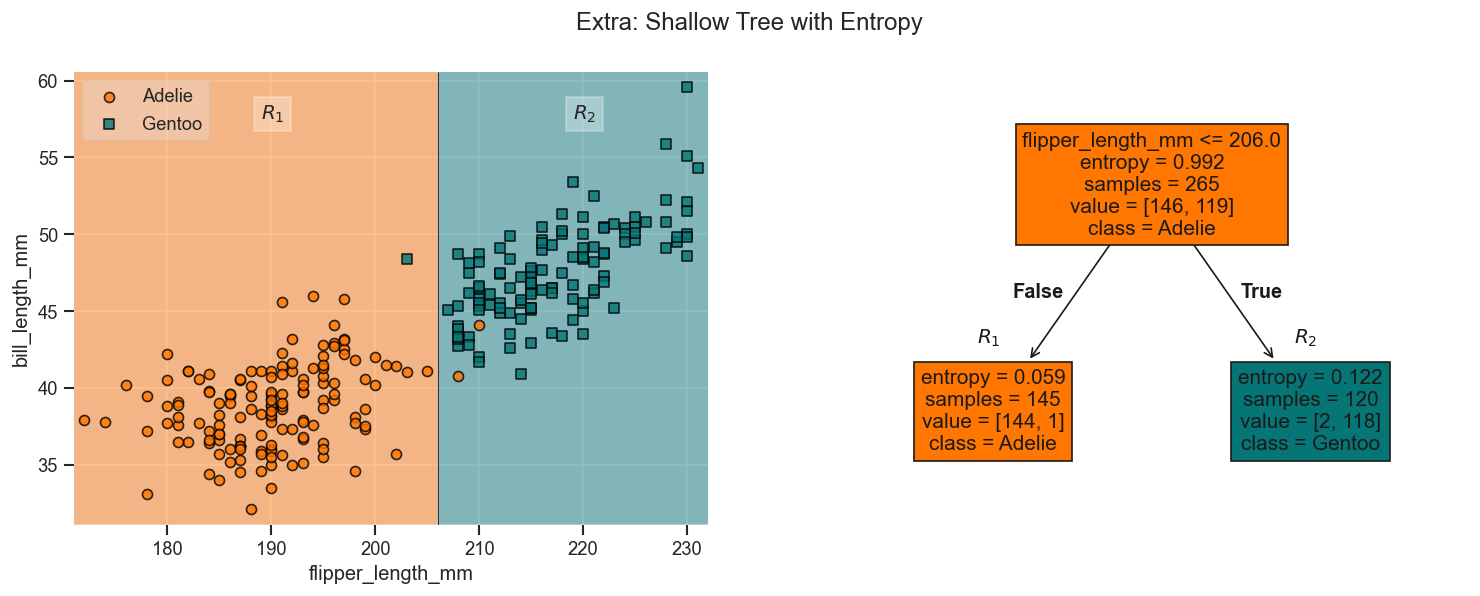

In [21]:
DT_e1 = DecisionTreeClassifier(criterion='entropy',
                               max_depth = 1,
                               random_state=42)

regions_tree(DT_e1, datasets['flbl']['X'], datasets['flbl']['y'], 
             datasets['flbl']['feats'], datasets['flbl']['class'], 
             col_dict,
             l_labels, r_labels, tp_labels, impurity = True,
             title = "Extra: Shallow Tree with Entropy"
            )

### Gini Impurity<sup>4</sup>
Gini Impurity is an alternative measurement, which minimises the probabilty of misclassification,

$$
\begin{align}
I_G(t) &= \sum^c_{i=1}p(i|t)(1-p(i|t))
\\
&= 1-\sum^c_{i=1}p(i|t)^2.
\end{align}
$$

This measure is also maximal when classes are perfectly mixed (e.g. $c=2$):

$$
\begin{align}
I_G(t) &= 1 - \sum^c_{i=1}0.5^2 = 0.5.
\end{align}
$$

__Notes__
- It is also a measure of node _"purity"_ as a small value indicates a node contains predominantly observations from a single class.
- Another way of writing this is<sup>1</sup> for $K$ classes, $G = \sum^K_{k=1}\hat p_{mk}(1-\hat p_{mk})$.
- It takes a small value if all of the $\hat p_{mk}$'s are close to 0 or 1.
- Whether we use entropy or Gini impurity does not really matter, because both have the same concave/bell shape.
- Gini is computationally more efficient to compute than entropy due to the lack of the log.

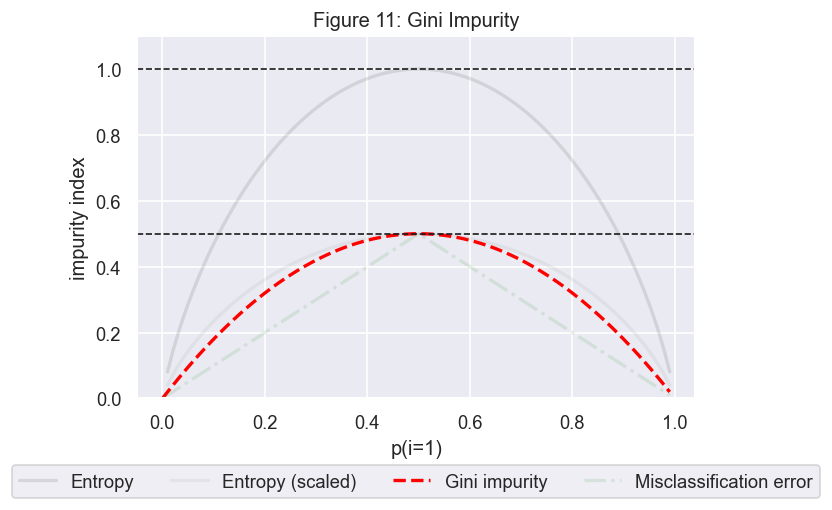

In [22]:
fig_num+=1
inf_gain_plot(plot_type="Gini",
              title="Figure %d: Gini Impurity"%fig_num)

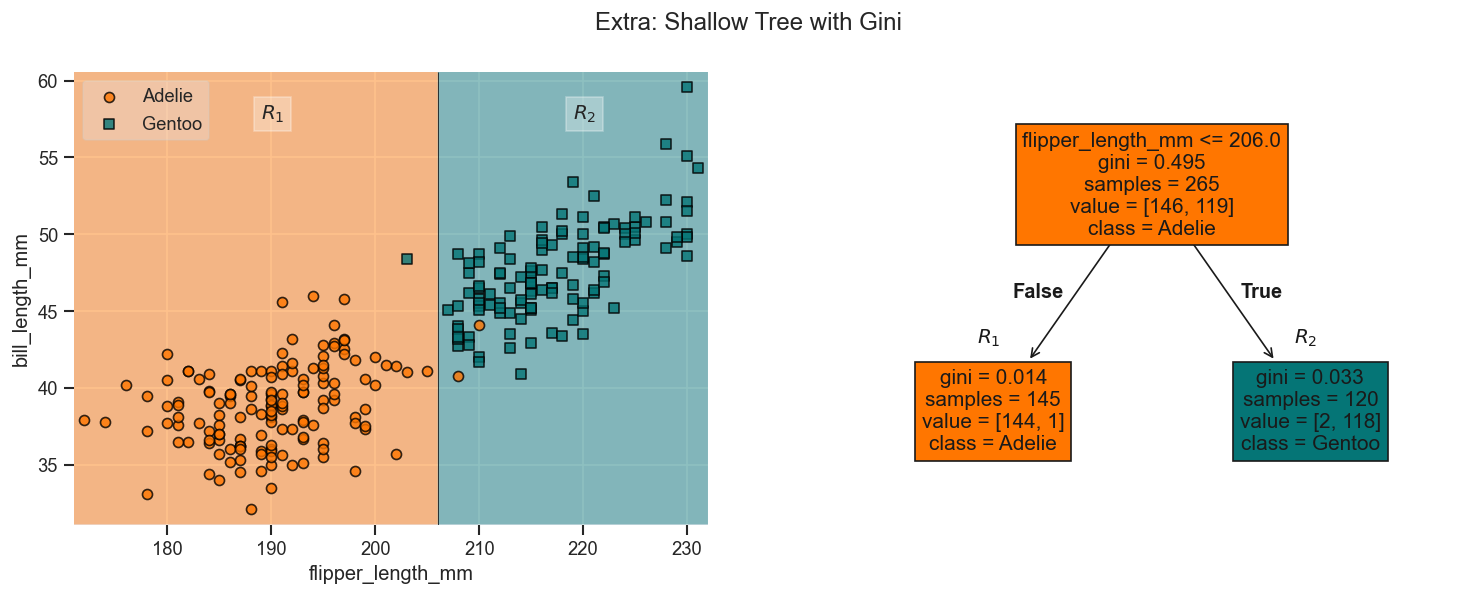

In [23]:
regions_tree(DT_g1, datasets['flbl']['X'], datasets['flbl']['y'], 
             datasets['flbl']['feats'], datasets['flbl']['class'], 
             col_dict, l_labels, r_labels, tp_labels, impurity = True,
             title = "Extra: Shallow Tree with Gini"
            )

### Why not Classification Error?

_Classification Error_ is rarely used for information gain in practice.

This is because it can mean that tree growth gets stuck and error doesnt improve, this is not the case for a concave function such as entropy or gini.

__Notes__
- Classification Error its not even an option in `scikit-learn`.
- Another example of this is given in exersise 3.

Figure 12: Child Node Averages


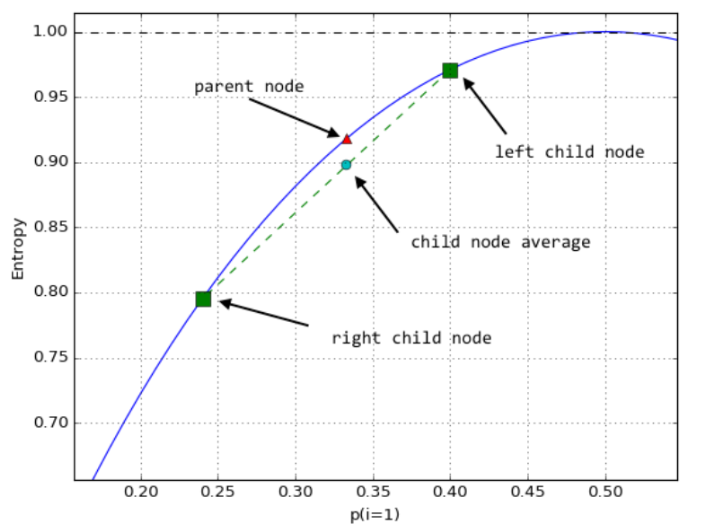

In [24]:
# taken from https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf
fig_num+=1
print(color.BOLD+color.UNDERLINE+"Figure %d: Child Node Averages"%fig_num+color.END)
Image(os.path.join(image_dir, "entropy_pc.png"), width=550)

### Feature Importance

Decision trees allow us assess the _importance_ of each feature for classifying the data.

The importance of a feature is the normalized total reduction of the criterion (e.g. Gini) brought by that feature<sup>10</sup>.

__[INSERT ALGEBRA]__

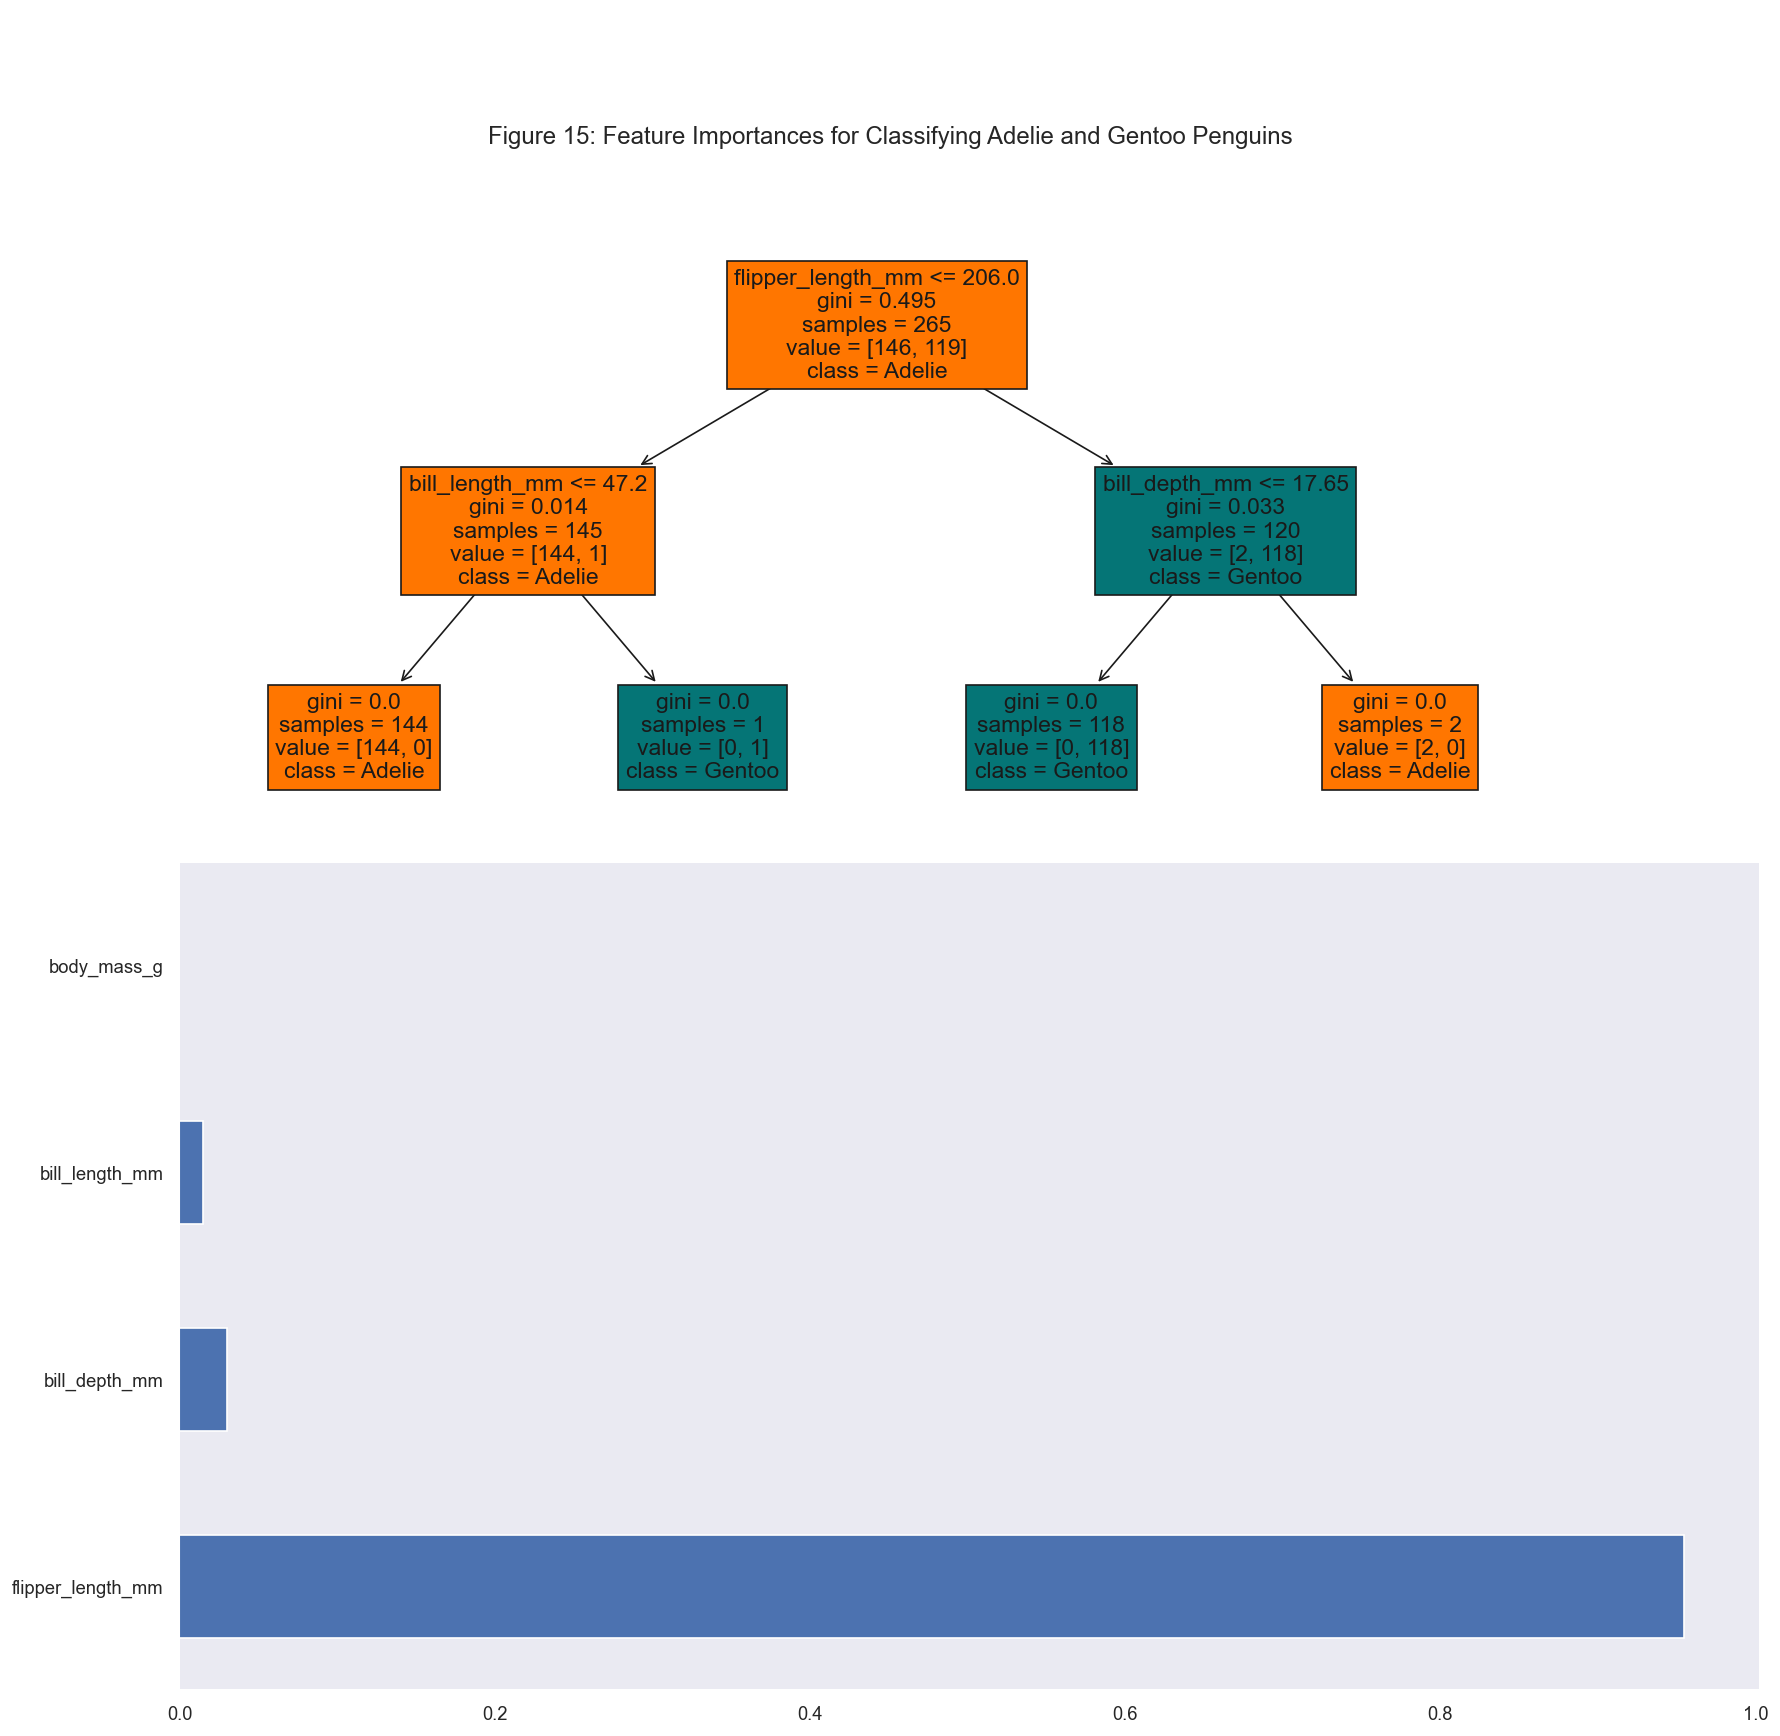

bill_length_mm: 0.015
bill_depth_mm: 0.030
flipper_length_mm: 0.955
body_mass_g: 0.000
total: 1.0


In [27]:
def tree_feat_import(DT, X, y, feat_names, class_names, title):

    DT.fit(X, y)
    # get the importances for the features
    importances = DT.feature_importances_

    importances_series = pd.Series(importances,index=feat_names).sort_values(ascending = False)
    
    fig, axes = plt.subplots(nrows = 2, figsize=(15,15))
    axes = axes.flatten()
    
    with plt.style.context("classic"):
        plt.sca(axes[0])
        tp = tree.plot_tree(DT,
                       feature_names=feat_names, 
                       class_names=class_names,
                       filled = True)
        for i, node in enumerate(tp):
            for class_name in datasets['bin']['class']:
                if search(class_name, node.get_text()):
                    tp[i].set_backgroundcolor(col_dict[class_name])

    plt.sca(axes[1])
    # plot the important features
    importances_series.plot.barh(legend =False, grid=False)
    plt.suptitle(title, y=0.9)
    plt.tight_layout()

    plt.show()

    # summarize feature importance
    for i,v in enumerate(importances):
        print(color.BOLD+feat_names[i]+color.END+": %.3f" % (v))

    print(color.BOLD+"total: "+color.END + str(round(sum(importances),2)))

fig_num+=1
tree_feat_import(DT_g, datasets['bin']['X'], datasets['bin']['y'], 
                 datasets['bin']['feats'],datasets['bin']['class'],
                 'Figure %d: Feature Importances for Classifying Adelie and Gentoo Penguins'%fig_num)

## Pruning
__Question:__ When do we stop growing a tree?

_Occam’s razor_: Favor a simpler hypothesis, because a simpler hypothesis that fits the data equally well is more likely or plausible than a complex one<sup>5</sup>.

To minimize overfitting, we can either set limits on the trees before building them (pre-pruning), or reduce the tree by removing branches that do not significantly contribute (post-pruning).

__NOTES__
- In other words, if decision trees are not pruned, they have a high risk of overfitting to the training data<sup>5</sup>.

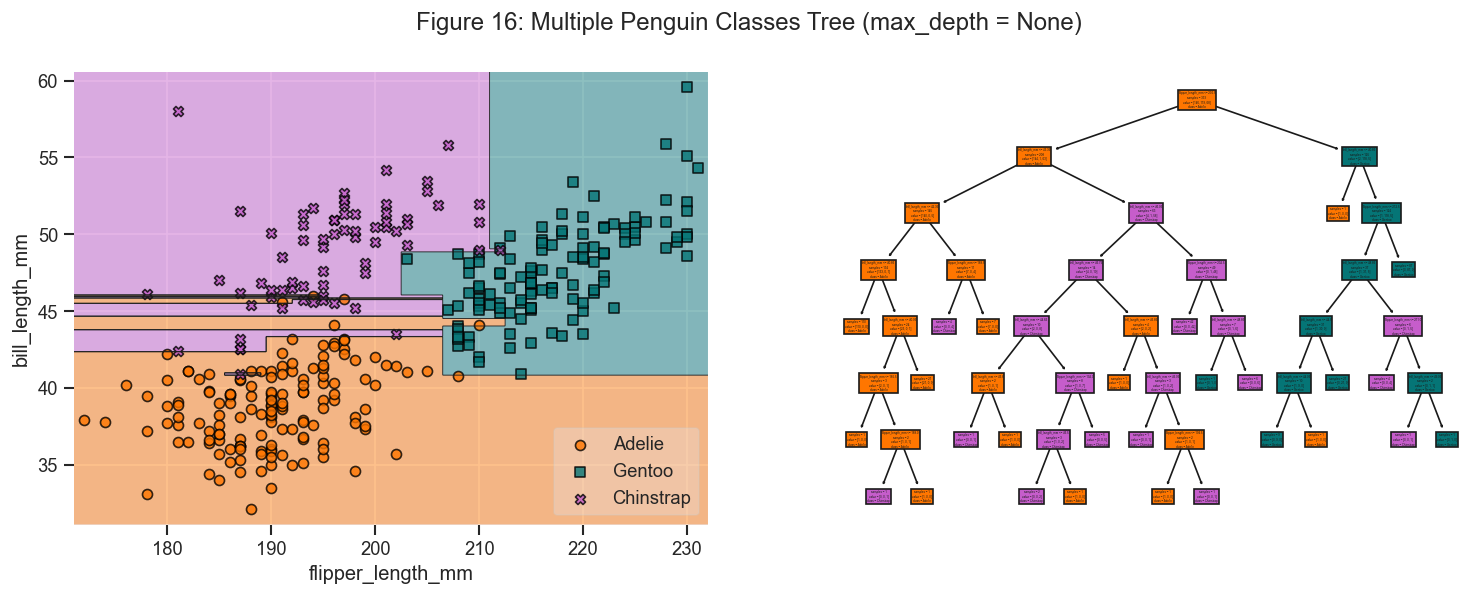

In [28]:
DT_g = DecisionTreeClassifier(criterion='gini',
                              random_state=42)
fig_num+=1   
regions_tree(DT_g, datasets['multi2']['X'], datasets['multi2']['y'], 
             datasets['multi2']['feats'], datasets['multi2']['class'], 
             col_dict,
             title="Figure %d: Multiple Penguin Classes Tree (max_depth = None)"%fig_num
            )         
plt.show()

In [35]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

def hyper_search(model, params, X, y, save_path, n_iter=60, metric="accuracy", 
                 cv = KFold(5), random_state=42, refit=True,
                 overwrite=False, warning=False):
    if os.path.exists(save_path) and overwrite==False:
        #load the model
        models = joblib.load(save_path)
    else:
        # check all param inputs are lists
        if all(type(x)==list for x in params.values()):
            search_type = "Gridsearch"
            models = GridSearchCV(model, param_grid=params, scoring=metric, cv=cv, 
                                  refit=refit, return_train_score=True)
            n_iter = len(list(itertools.product(*list(iter(params.values())))))
        else:
            search_type = "Randomsearch"
            models = RandomizedSearchCV(model, param_distributions=params,
                                        n_iter=n_iter, scoring=metric, cv=cv,
                                        refit=refit, random_state=random_state,
                                        return_train_score=True)
        
        start = time()
        if warning:
            models.fit(X, y)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                models.fit(X, y)
        
        print(search_type + " took %.2f seconds for %d candidates" % ((time() - start), n_iter))
        joblib.dump(models, save_path)
    
    return models

# specify parameters and distributions to sample from
param_grid = {"max_depth":list(range(1,15))}

depth_gs = hyper_search(DT_g, param_grid, datasets['multi2']['X'], datasets['multi2']['y'],
                        os.path.join(os.getcwd(), "Models", "pen_depth_gs_object.pkl"), 
                        overwrite=False)

pd.DataFrame(depth_gs.cv_results_).sort_values("rank_test_score")[["param_max_depth", "mean_test_score", "std_test_score"]].head()

Gridsearch took 0.12 seconds for 14 candidates


param_max_depth  mean_test_score  std_test_score
1               2         0.913026        0.053897
3               4         0.871009        0.114660
8               9         0.871009        0.058487
2               3         0.852782        0.079683
4               5         0.843600        0.056577

Using GridSearch, the best maximum tree depth was found to be: 2


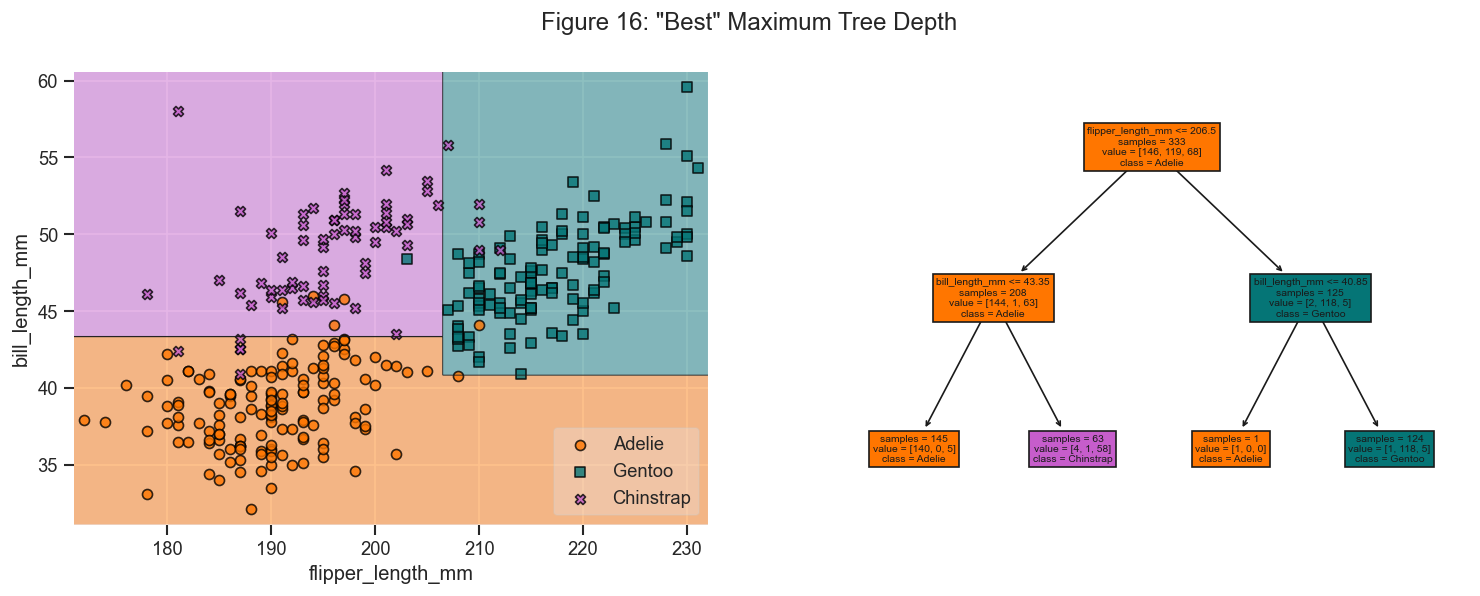

In [37]:
print("Using GridSearch, the best maximum tree depth was found to be: "+str(list(depth_gs.best_params_.values())[0]))
regions_tree(depth_gs.best_estimator_, datasets['multi2']['X'], datasets['multi2']['y'], 
             datasets['multi2']['feats'], datasets['multi2']['class'], 
             col_dict, title= 'Figure %d: "Best" Maximum Tree Depth'%fig_num
            )

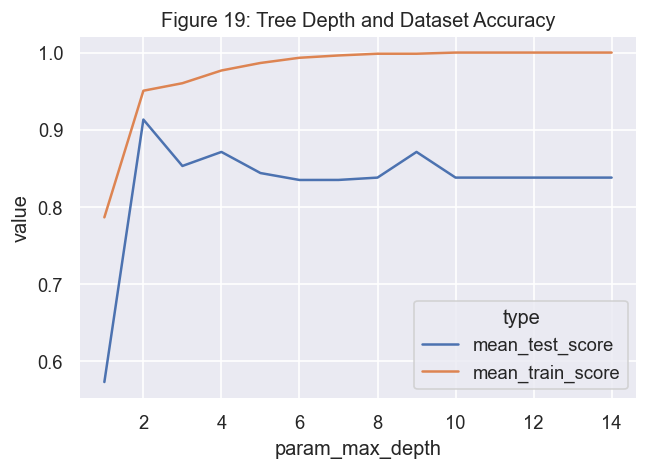

In [61]:
cols = ["param_max_depth", "mean_test_score", "mean_train_score"]

scores_df = pd.DataFrame(depth_gs.cv_results_).sort_values("param_max_depth")[cols]

scores_df = pd.melt(scores_df, value_vars=['mean_test_score','mean_train_score'],
                     id_vars=['param_max_depth'], var_name = ['type'])

fig_num+=1
sns.lineplot(data = scores_df, x='param_max_depth', y = 'value', hue = 'type')
plt.title('Figure %d: Tree Depth and Dataset Accuracy'%fig_num)
plt.show()

In [82]:
# specify parameters and distributions to sample from
param_grid = {"min_samples_leaf":list(range(1,25))}

lsamples_gs = hyper_search(DT_g, param_grid, datasets['multi2']['X'], datasets['multi2']['y'],
                           os.path.join(os.getcwd(), "Models", "pen_lsamples_gs_object.pkl"), 
                           overwrite=True)

pd.DataFrame(lsamples_gs.cv_results_).sort_values("rank_test_score")[["param_min_samples_leaf", "mean_test_score", "std_test_score"]].head()

Gridsearch took 0.19 seconds for 24 candidates


param_min_samples_leaf  mean_test_score  std_test_score
19                     20         0.912981        0.048646
21                     22         0.912981        0.048646
17                     18         0.912981        0.048646
16                     17         0.912981        0.048646
20                     21         0.912981        0.048646

Using GridSearch, the best minimum samples per leaf was found to be: 17


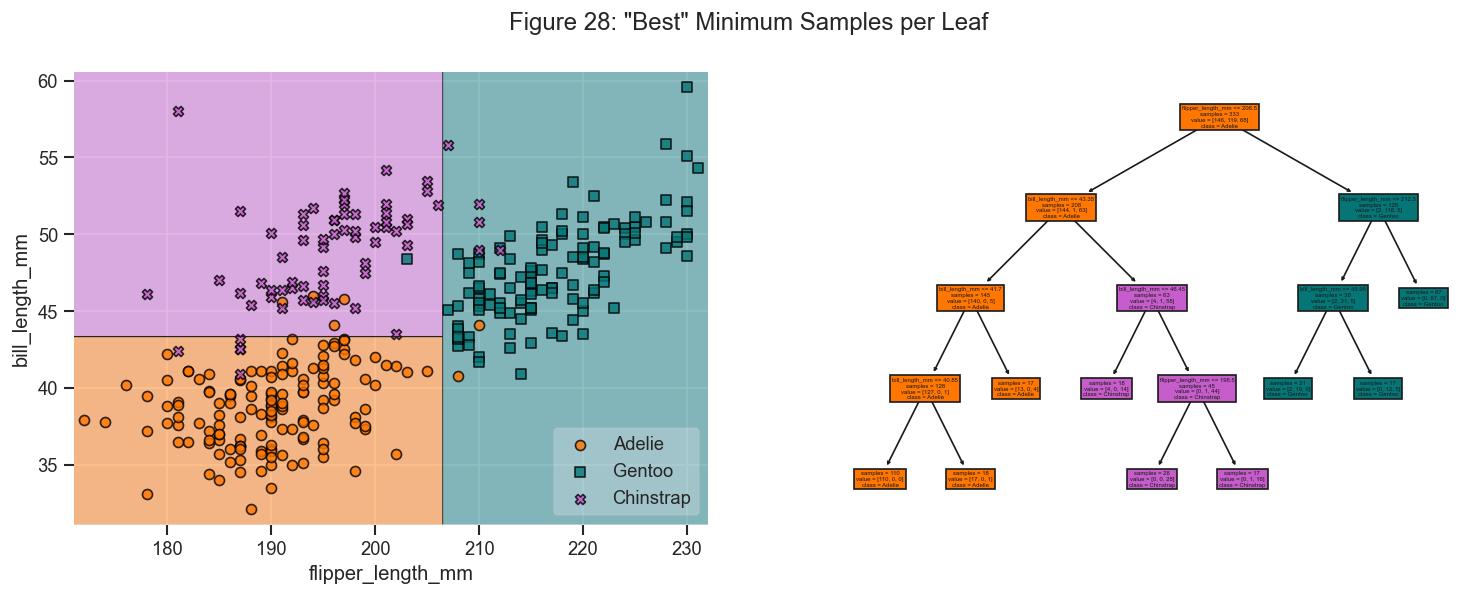

In [83]:
print("Using GridSearch, the best minimum samples per leaf was found to be: "+str(list(lsamples_gs.best_params_.values())[0]))
fig_num+=1
regions_tree(lsamples_gs.best_estimator_, datasets['multi2']['X'], datasets['multi2']['y'], 
             datasets['multi2']['feats'], datasets['multi2']['class'], col_dict, 
             title = 'Figure %d: "Best" Minimum Samples per Leaf'%fig_num)

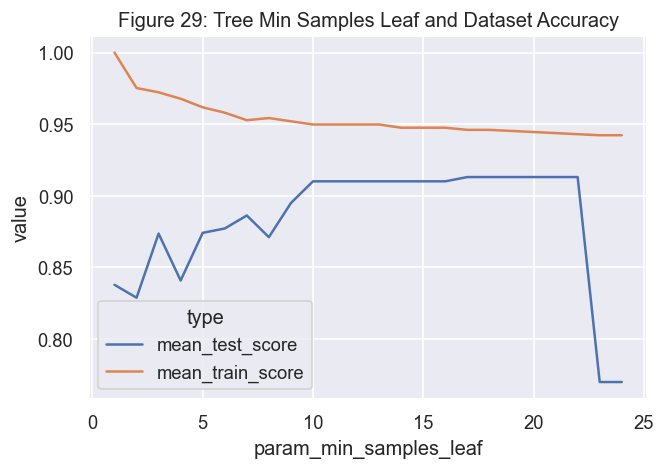

In [85]:
cols = ["param_min_samples_leaf", "mean_test_score", "mean_train_score"]

scores_df = pd.DataFrame(lsamples_gs.cv_results_).sort_values("param_min_samples_leaf")[cols]

scores_df = pd.melt(scores_df, value_vars=['mean_test_score','mean_train_score'],
                     id_vars=['param_min_samples_leaf'], var_name = ['type'])

fig_num+=1
sns.lineplot(data = scores_df, x='param_min_samples_leaf', y = 'value', hue = 'type')
plt.title('Figure %d: Tree Min Samples Leaf and Dataset Accuracy'%fig_num)
plt.show()

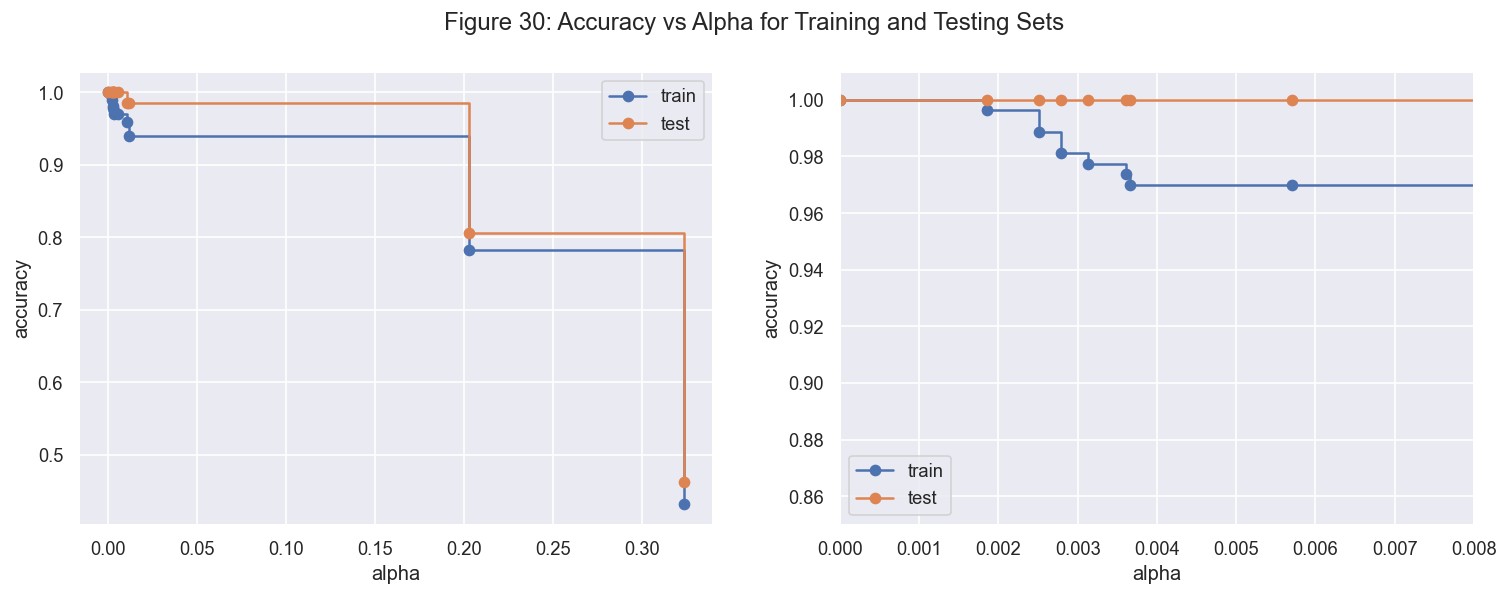

In [86]:
# https://github.com/krishnaik06/Post_Pruning_DecisionTre/blob/master/plot_cost_complexity_pruning.ipynb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(datasets['multi2']['X'], datasets['multi2']['y'],
                                                    test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(datasets['multi2']['X'], datasets['multi2']['y'], 
                                                    test_size = 0.2, random_state=42)

DT = DecisionTreeClassifier(criterion='gini',
                            random_state=42)
path = DT.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
#print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#      clfs[-1].tree_.node_count, ccp_alphas[-1]))


train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    if i ==1:
        ax.set_xlim(0.,0.008)
        ax.set_ylim(0.85,1.01)

fig_num+=1
plt.suptitle("Figure %d: Accuracy vs Alpha for Training and Testing Sets"%fig_num)
plt.show()

### Dataset Example: X <a id='data2'></a>

`load_breast_cancer`

In [26]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
display(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

None

__Extra__

You can explore the data below although I recomend limiting the number of features to plot for ease.

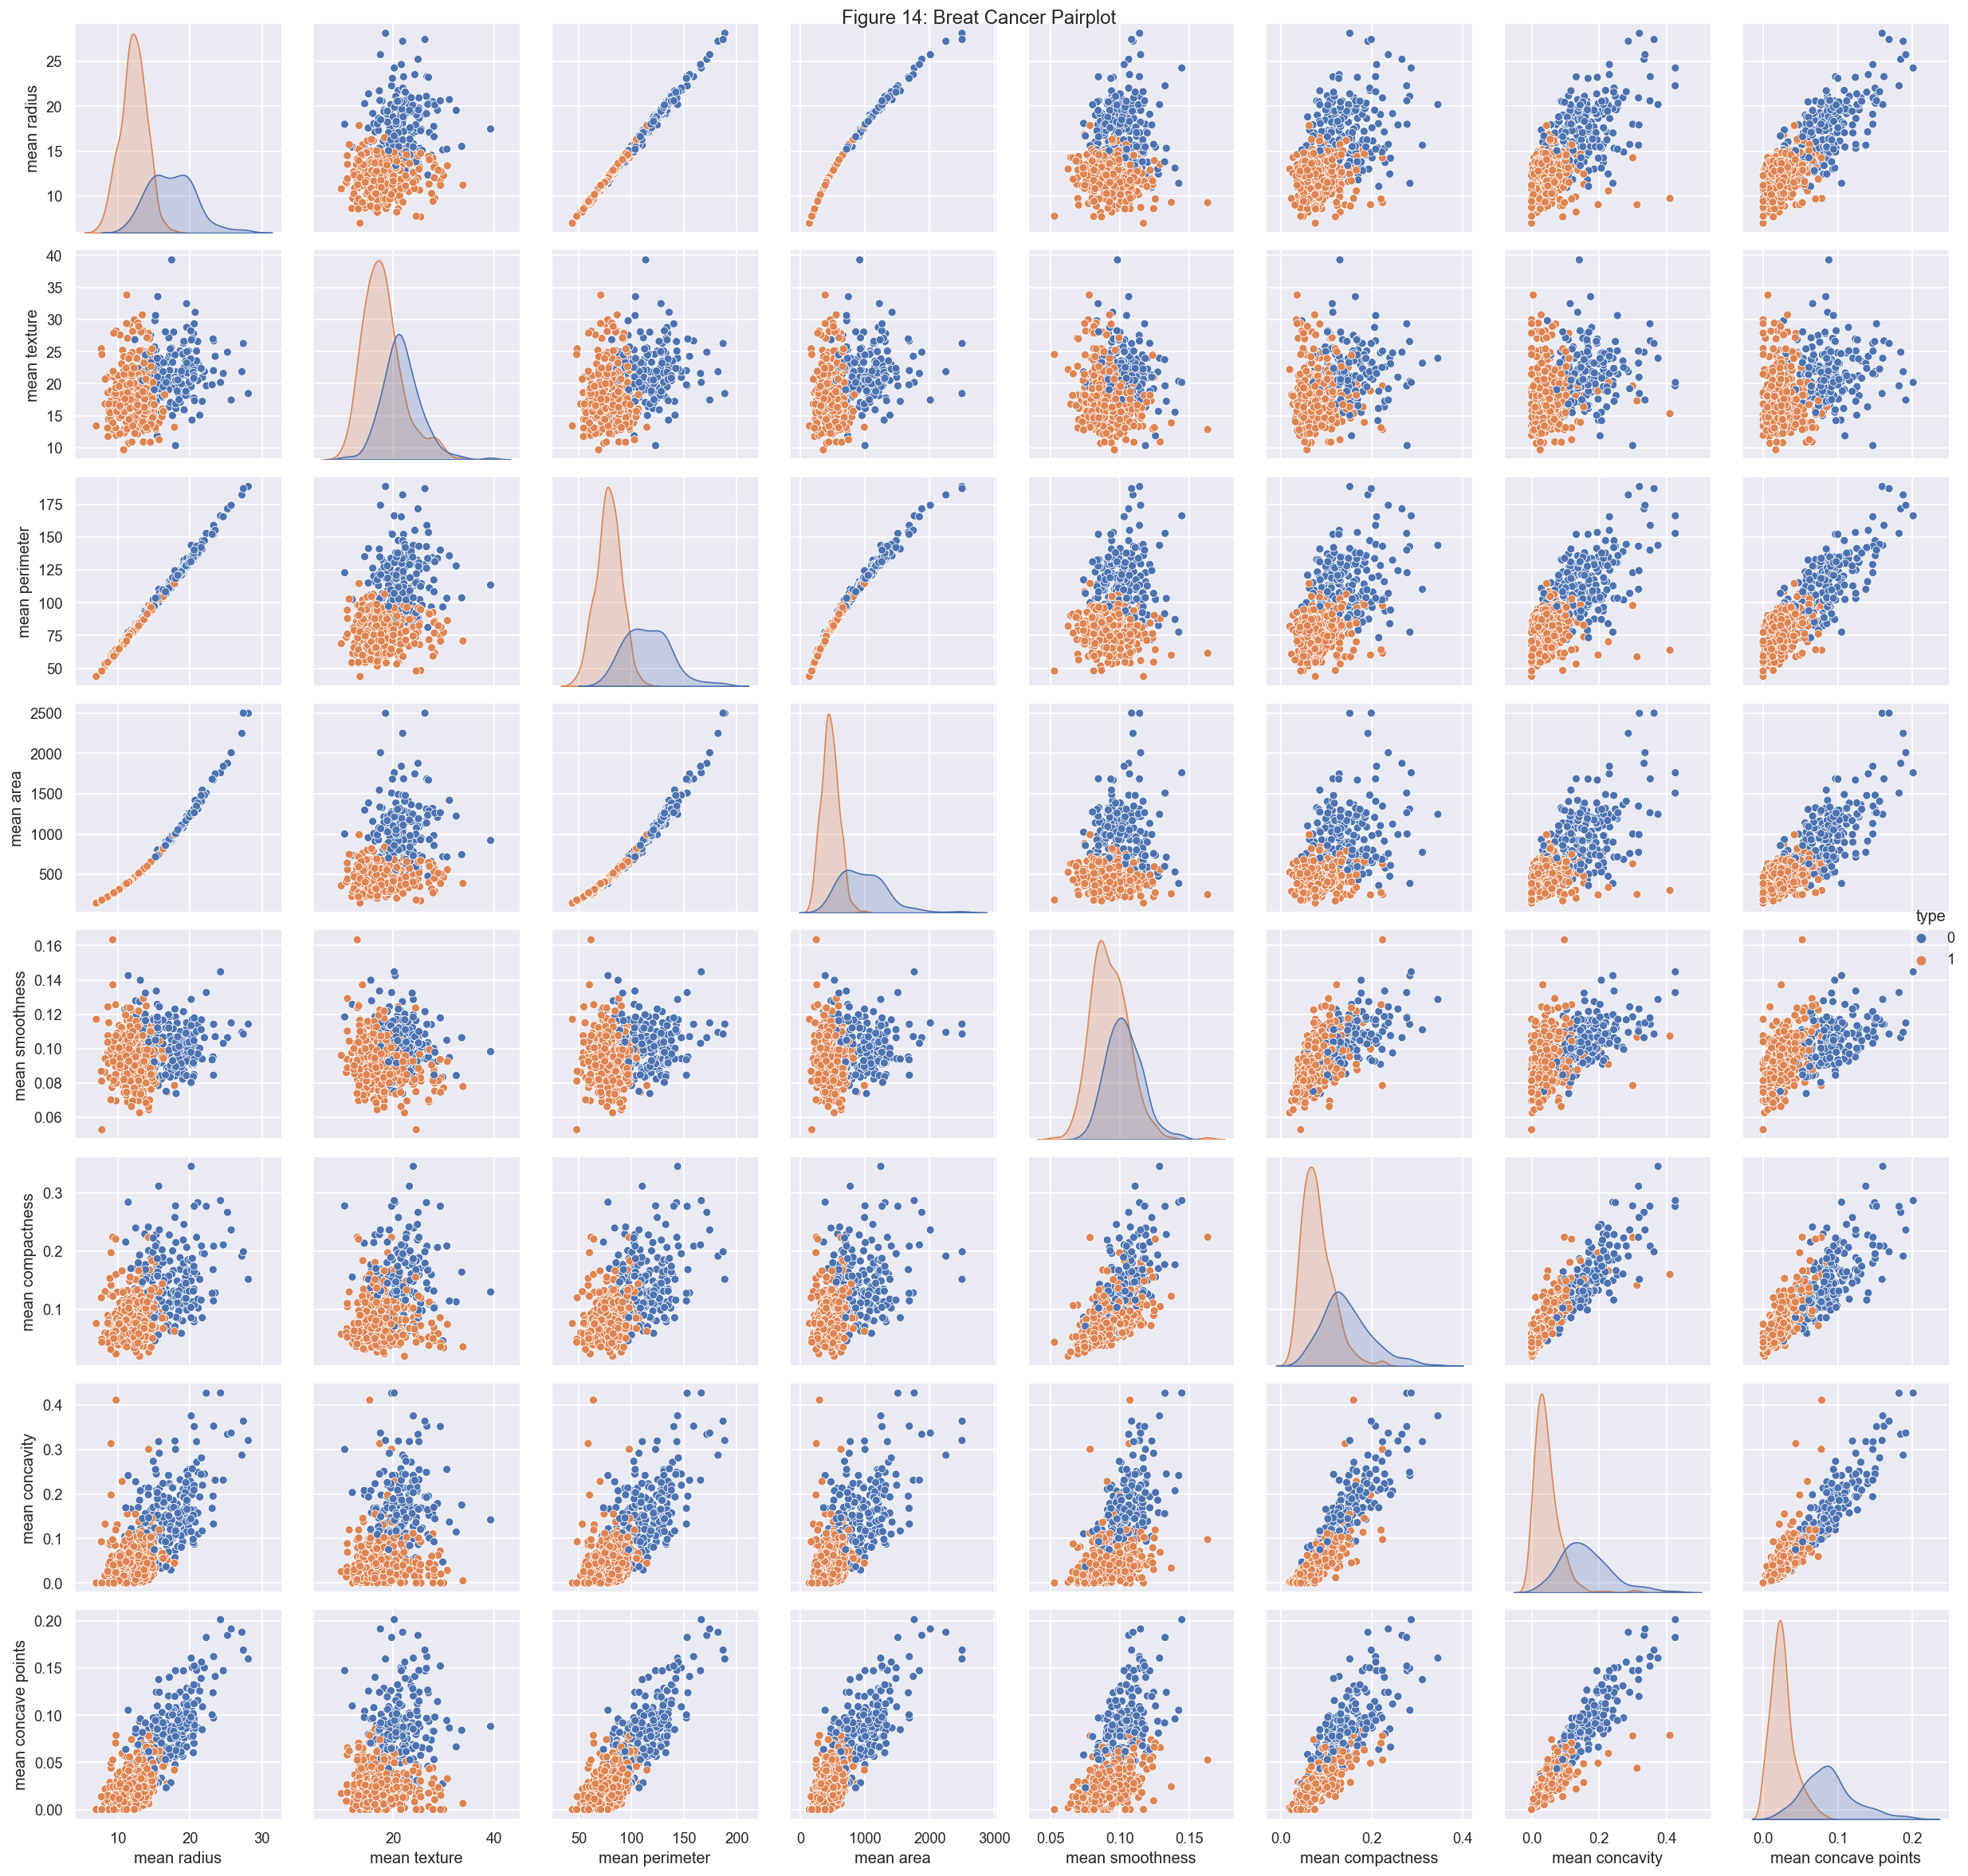

In [27]:
X_plot = X.copy()
X_plot['type'] = y

fig_num+=1
sns.pairplot(X_plot.iloc[:,:8].join(X_plot.iloc[:,-1]), hue='type')
plt.suptitle("Figure %d: Breat Cancer Pairplot"%fig_num)
plt.tight_layout()
plt.show()

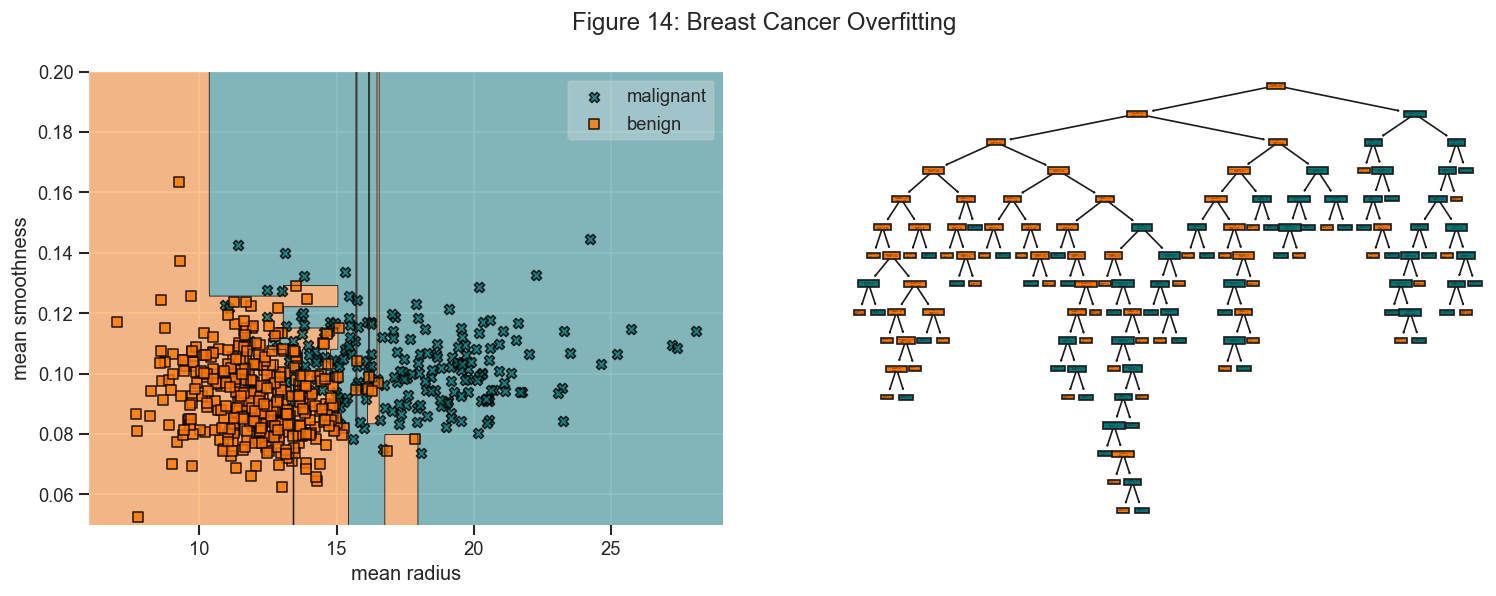

In [28]:
col_dict = {
    "benign":"#ff7600",
    "malignant":"#057576"}

shape_dict = {
    "benign":"o",
    "malignant":"X"}

DT_g = DecisionTreeClassifier(criterion='gini',
                               random_state=42)

cancer_features = ['mean radius','mean smoothness']
regions_tree(DT_g, X[cancer_features].values, y.values, cancer_features, 
             load_breast_cancer().target_names, col_dict, yaxis_lim=[0.05,0.20],
             title = "Figure %d: Breast Cancer Overfitting"%fig_num
            )

### Pre-Pruning

An a priori limit on nodes, or tree depth, is often set to avoid overfitting due to a deep tree<sup>4,5</sup>.

__Notes__
- Another one is to stop growing if a split is not statistically significant (e.g., $\chi^2$ test)<sup>5</sup>. However this is not yet availble in `sklearn`, although I'm sure you can find some code for it somewhere on the internet.

In [29]:
def hyper_search(model, params, X, y, save_path, n_iter=60, random_state=42, overwrite=False):
    if os.path.exists(save_path) and overwrite==False:
        #load the model
        models = joblib.load(save_path)
    else:
        # check all param inputs are lists
        if all(type(x)==list for x in params.values()):
            search_type = "Gridsearch"
            models = GridSearchCV(model, param_grid=params)
            n_iter = len(list(itertools.product(*list(iter(params.values())))))
        else:
            search_type = "Randomsearch"
            models = RandomizedSearchCV(model, param_distributions=params,
                                        n_iter=n_iter, random_state=random_state)
        
        start = time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            models.fit(X, y)
        
        print(search_type + " took %.2f seconds for %d candidates" % ((time() - start), n_iter))
        joblib.dump(models, save_path)
    
    return models

# specify parameters and distributions to sample from
param_grid = {"max_depth":list(range(1,15))}

depth_gs = hyper_search(DT_g, param_grid, X[cancer_features].values, y,
                        os.path.join(os.getcwd(), "Models", "depth_gs_object.pkl"), 
                        overwrite=False)

pd.DataFrame(depth_gs.cv_results_).sort_values("rank_test_score")[["param_max_depth", "mean_test_score", "std_test_score"]].head()

param_max_depth  mean_test_score  std_test_score
0                1         0.889334        0.045855
2                3         0.884024        0.032951
10              11         0.875190        0.029179
13              14         0.875190        0.029179
5                6         0.873374        0.044245

Using GridSearch, the best maximum tree depth was found to be: 1


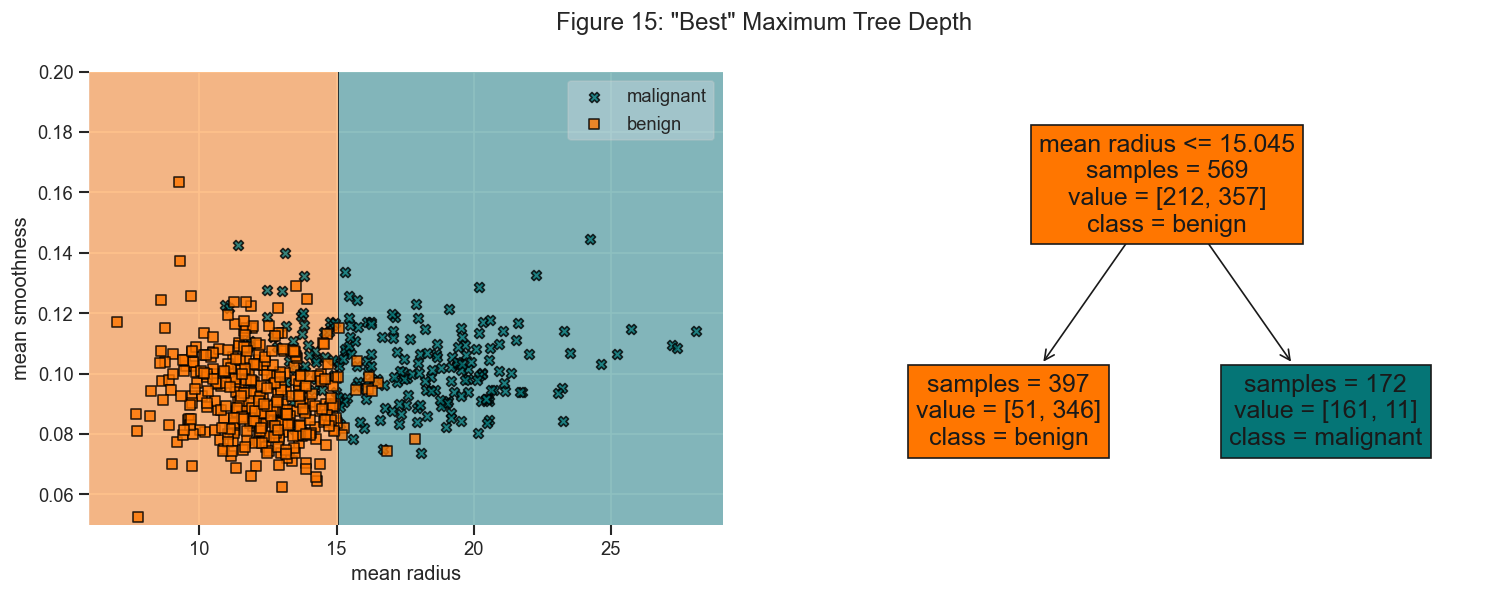

In [30]:
fig_num+=1
print("Using GridSearch, the best maximum tree depth was found to be: "+str(list(depth_gs.best_params_.values())[0]))
regions_tree(depth_gs.best_estimator_, X[cancer_features].values, y.values, 
             cancer_features, load_breast_cancer().target_names, col_dict, 
             yaxis_lim = [0.05,0.20], title= 'Figure %d: "Best" Maximum Tree Depth'%fig_num
            )

__TODO__
- turn this into a function
- pull these numbers out of the gridsearch and dont do them again as they are not fully correct!

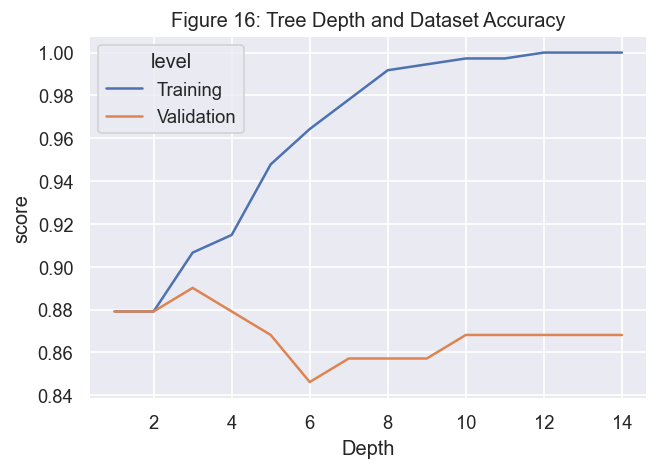

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[cancer_features].values, y.values,
                                                    test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.2, random_state=42)
scores_df = pd.DataFrame()
for depth in param_grid["max_depth"]:
    DT = DecisionTreeClassifier(criterion='gini',
                                max_depth = depth,
                                random_state=42).fit(X_train, y_train)
    train_score = accuracy_score(y_train, DT.predict(X_train))
    val_score = accuracy_score(y_val, DT.predict(X_val))
    depth_df = pd.DataFrame([depth, train_score, val_score], index = ["Depth", "Training", 'Validation'])
    
    if depth == 1:
        scores_df = depth_df
    else:
        scores_df = pd.concat([scores_df, depth_df], axis=1)
        
scores_df = scores_df.T
scores_df = pd.pivot(scores_df, values=['Training','Validation'],
                    columns=['Depth']).T.reset_index()

scores_df.columns = ['level', 'Depth', 'score']

fig_num+=1
sns.lineplot(data = scores_df, x='Depth', y = 'score', hue = 'level')
plt.title('Figure %d: Tree Depth and Dataset Accuracy'%fig_num)
plt.show()

We could also set a minimum number of data points for each node<sup>5</sup>.

In [32]:
# specify parameters and distributions to sample from
param_grid = {"min_samples_leaf":list(range(1,15))}

lsamples_gs = hyper_search(DT_g, param_grid, X[cancer_features].values, y,
                           os.path.join(os.getcwd(), "Models", "lsamples_gs_object.pkl"), 
                           overwrite=False)

pd.DataFrame(lsamples_gs.cv_results_).sort_values("rank_test_score")[["param_min_samples_leaf", "mean_test_score", "std_test_score"]].head()

param_min_samples_leaf  mean_test_score  std_test_score
12                     13         0.892796        0.037784
13                     14         0.892796        0.037784
10                     11         0.889287        0.041346
8                       9         0.887549        0.043764
9                      10         0.887533        0.040511

Using GridSearch, the best minimum samples per leaf was found to be: 13


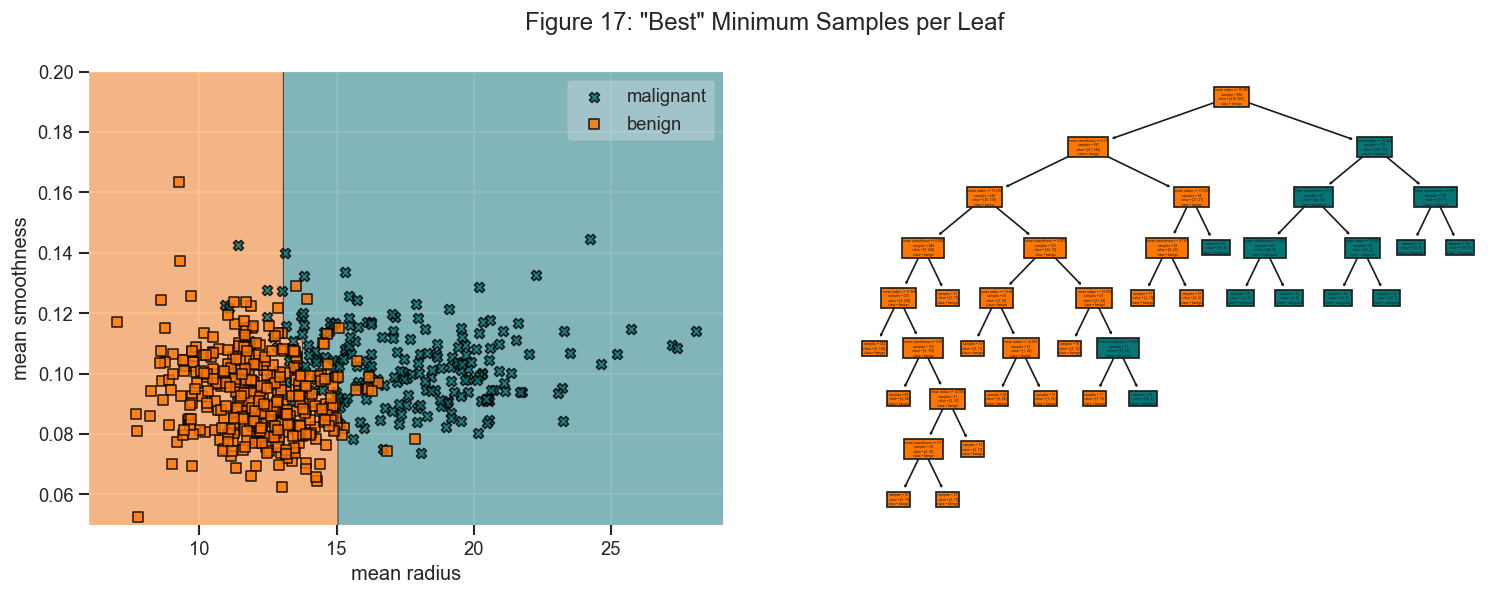

In [33]:
print("Using GridSearch, the best minimum samples per leaf was found to be: "+str(list(lsamples_gs.best_params_.values())[0]))
fig_num+=1
regions_tree(lsamples_gs.best_estimator_, X[cancer_features].values, y.values, 
             cancer_features, load_breast_cancer().target_names, col_dict, 
             yaxis_lim = [0.05,0.20], title = 'Figure %d: "Best" Minimum Samples per Leaf'%fig_num)

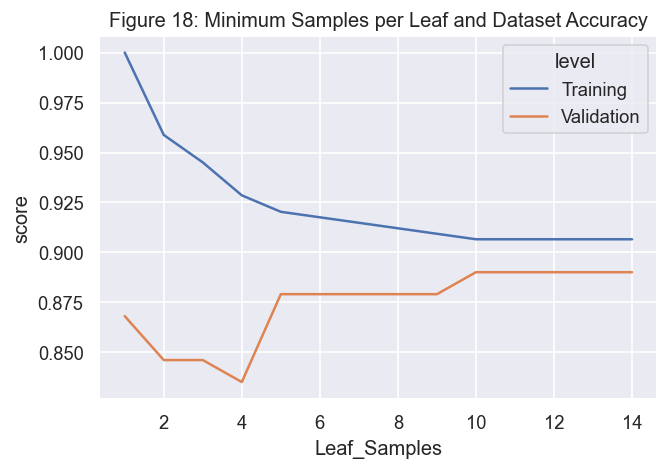

In [34]:
scores_df = pd.DataFrame()
for samples in param_grid["min_samples_leaf"]:
    DT = DecisionTreeClassifier(criterion='gini',
                                min_samples_leaf = samples,
                                random_state=42).fit(X_train, y_train)
    train_score = accuracy_score(y_train, DT.predict(X_train))
    val_score = accuracy_score(y_val, DT.predict(X_val))
    samples_df = pd.DataFrame([samples, train_score, val_score], index = ["Leaf_Samples", "Training", 'Validation'])
    
    if samples == 1:
        scores_df = samples_df
    else:
        scores_df = pd.concat([scores_df, samples_df], axis=1)
        
scores_df = scores_df.T
scores_df = pd.pivot(scores_df, values=['Training','Validation'],
                    columns=['Leaf_Samples']).T.reset_index()

scores_df.columns = ['level', 'Leaf_Samples', 'score']

sns.lineplot(data = scores_df, x='Leaf_Samples', y = 'score', hue = 'level')
fig_num+=1
plt.title('Figure %d: Minimum Samples per Leaf and Dataset Accuracy'%fig_num)
plt.show()

### Post-Pruning
In general, post-pruning consists of going back through the tree once it has been created and removing branches that do not significantly contribute to the error reduction and replacing them with leaf nodes<sup>6</sup>

Two common approaches are _reduced-error pruning_ and _cost-complexity pruning_
- __Reduced-error pruning__<sup>5</sup>
    - Greedily remove nodes based on validation set performance
    - Generally improves performance but can be problematic for limited data set sizes.
- __Cost-complexity pruning__<sup>5</sup>
    - Recursively finds the node with the “weakest link”.
    - Nodes are characterized by $\alpha \geq 0$, and nodes with the smallest effective $\alpha$ are pruned first<sup>7</sup>.
    - The trees are then defined as $I + \alpha|N|$, where $I$ is an impurity measure, such as the total misclassification rate of the terminal nodes, $\alpha$ is a tuning parameter, and $|N|$ is the total number of nodes<sup>5</sup>.

#### Cost-complexity pruning<sup>7</sup>
Using `Scikit-learn`, we can recursively fit a complex tree with no prior pruning and have a look at the effective alphas and the corresponding total leaf impurities at each step of the pruning process.

As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better.

We can select the alpha that reduces the distance between the train and validation scores.

__Notes__
- In `Scikit-learn` 0.22 the parameter `ccp_alpha` was introduced (short for Cost Complexity Pruning- Alpha)
- `DecisionTreeClassifier.cost_complexity_pruning_path` returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process.

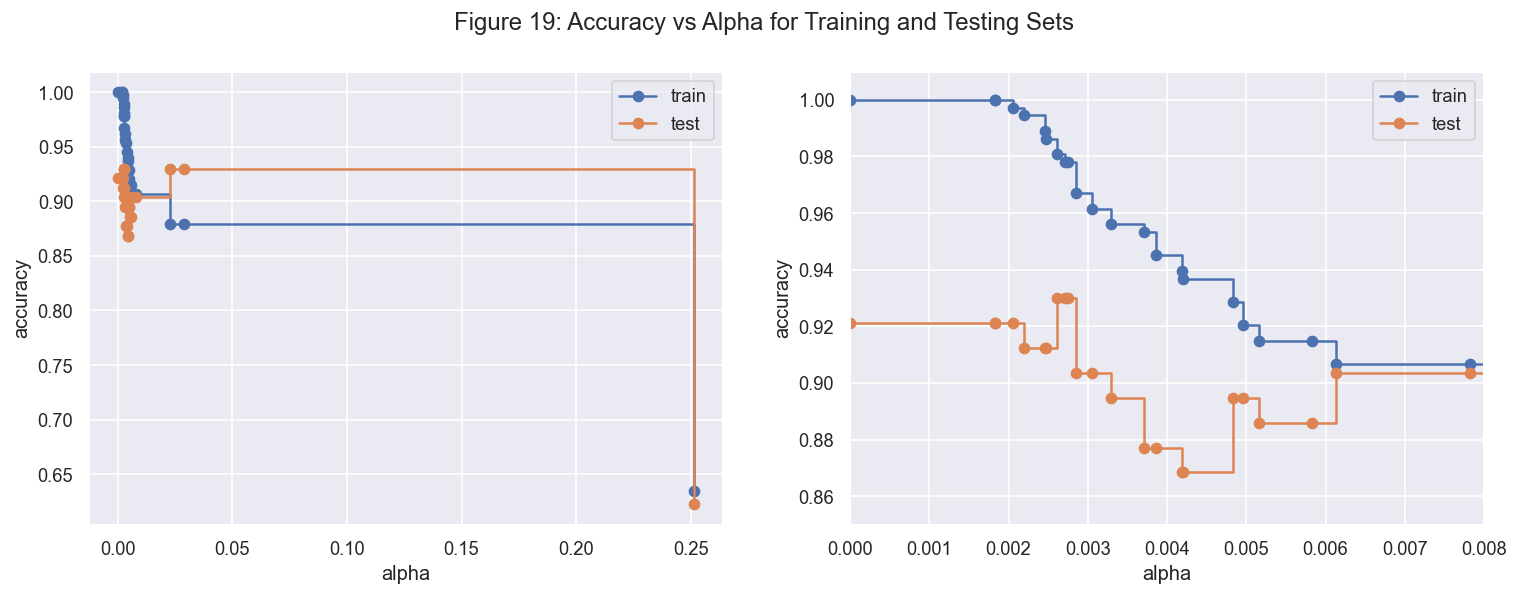

In [35]:
# https://github.com/krishnaik06/Post_Pruning_DecisionTre/blob/master/plot_cost_complexity_pruning.ipynb
DT = DecisionTreeClassifier(criterion='gini',
                            random_state=42)
path = DT.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
#print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#      clfs[-1].tree_.node_count, ccp_alphas[-1]))


train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    if i ==1:
        ax.set_xlim(0.,0.008)
        ax.set_ylim(0.85,1.01)

fig_num+=1
plt.suptitle("Figure %d: Accuracy vs Alpha for Training and Testing Sets"%fig_num)
plt.show()

Then we can train a decision tree using the chosen effective alpha.

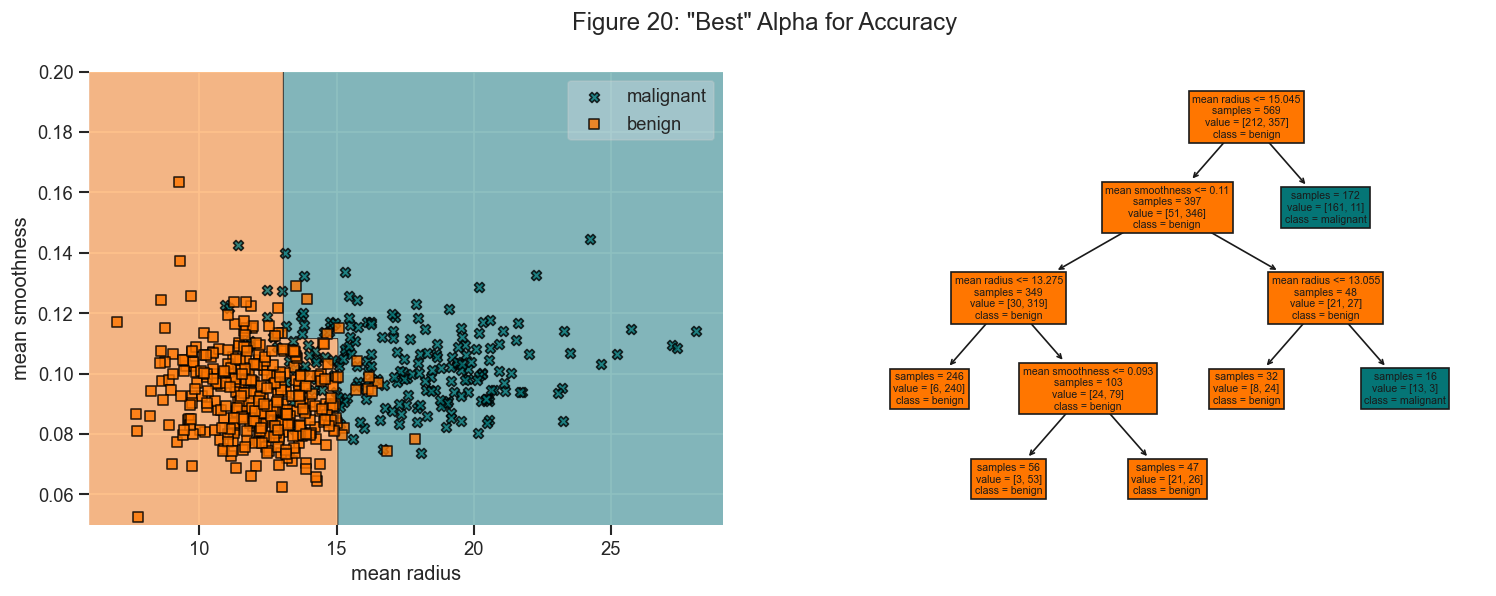

mean radius: 0.902
mean smoothness: 0.098


In [36]:
DT_ccp = DecisionTreeClassifier(criterion='gini',
                               random_state=42,
                               ccp_alpha = 0.0065                            
                              )
fig_num+=1
regions_tree(DT_ccp, X[cancer_features].values, y.values, 
             cancer_features, load_breast_cancer().target_names, 
             col_dict, yaxis_lim = [0.05,0.20],
             title = 'Figure %d: "Best" Alpha for Accuracy'%fig_num
            )

# get the importances for the features
importances = DT_ccp.feature_importances_

importances_series = pd.Series(importances,index=cancer_features).sort_values(ascending = False)

# summarize feature importance
for i,v in enumerate(importances):
    print(color.BOLD+cancer_features[i]+color.END+": %.3f" % (v))

### Other Algorithms

__ID3 - Iterative Dichotomizer 3__<sup>8</sup>

- __Splitting Criterion:__ Maximises Information Gain/ Minimises Entropy
- __Number of Splits:__ Multiway
- __Variables:__ Discrete binary and multi-category features
- __Pruning__: None

__C4.5__<sup>9</sup>

- __Splitting Criterion:__  Maximises Information Gain/ Minimises Entropy
- __Number of Splits:__ Multiway
- __Variables:__ Discrete & Continuous (expensive)
- __Pruning__: Post-Pruning
- can handle missing data
- C5.0 is the latest release version under a proprietary license

__Notes__
- you can read an introduction to ID3 in pgs.27-30 of Burkov (2019)

# Associated Exercises

Now might be a good time to try exercises X-X.

# References
1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
2. Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
4. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
5. https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf
6. Burkov, A. (2019). The hundred-page machine learning book (Vol. 1). Canada: Andriy Burkov.
7. https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#:~:text=Cost%20complexity%20pruning%20provides%20another,the%20number%20of%20nodes%20pruned.
8. Quinlan, J. R. (1986). Induction of decision trees. Machine learning, 1 (1), 81-106
9. Quinlan, J. R. (1993). C4. 5: Programming for machine learning. Morgan Kauffmann, 38, 48.
10. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [37]:
import sys
from shutil import copyfile

# where the HTML template is located
dst = os.path.join(sys.prefix, 'lib', 'site-packages', 'nbconvert', 'templates', "classic.tplx")

# If its not located where it should be
if not os.path.exists(dst):
    # uses a nb_pdf_template
    curr_path = os.path.join(os.getcwd(),"..", "Extra", "classic.tplx")
    # copy where it is meant to be
    copyfile(curr_path, dst)

   
# Create HTML notes document (preferred)
!jupyter nbconvert 1_Decision_Trees.ipynb \
    --to html \
    --output-dir . \
    --template classic
# Create html slides (issues)
!jupyter nbconvert 1_Decision_Trees.ipynb \
    --to slides \
    --output-dir . \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True \
    --SlidesExporter.reveal_scroll=True

# Create pdf notes document (issues)
!jupyter nbconvert 1_Decision_Trees.ipynb \
    --to html \
    --output-dir ./PDF_Prep \
    --output 1_Decision_Trees_no_code \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True

[NbConvertApp] Converting notebook 1_Decision_Trees.ipynb to html
[NbConvertApp] Writing 4409050 bytes to 1_Decision_Trees.html
[NbConvertApp] Converting notebook 1_Decision_Trees.ipynb to slides
[NbConvertApp] Writing 3995995 bytes to 1_Decision_Trees.slides.html
[NbConvertApp] Converting notebook 1_Decision_Trees.ipynb to html
[NbConvertApp] Writing 4553426 bytes to PDF_Prep\1_Decision_Trees_no_code.html
